# Extract GPS data from dashcam footage - Version 5
gps_bend_finding_with_gaussian_smoothing_and_DBSCAN_clustering_and_circle_fitting - Version 5

In [250]:
ids = [12]
min_string_length = 9
DATASET_PATH = "/home/aap9002/Stereo-Road-Curvature-Dashcam"
min_speed_filter = 5

In [251]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from sklearn.cluster import DBSCAN
from pyproj import Transformer
import argparse

### Pipeline support with passing forced parameters

In [252]:
parser = argparse.ArgumentParser(
    description="Process input and output paths for video processing."
)

parser.add_argument(
    "-i", "--input", 
    help="Path to the input video file.", 
    required=False
)

parser.add_argument(
    "-o", "--output", 
    help="Path to the output folder.", 
    required=False
)

parser.add_argument(
    "--f", "--kernel_launcher", 
    help="Path to the kernel launcher file.",
    required=False
)

_StoreAction(option_strings=['--f', '--kernel_launcher'], dest='f', nargs=None, const=None, default=None, type=None, choices=None, required=False, help='Path to the kernel launcher file.', metavar=None)

In [253]:
args = parser.parse_args()

if args.input and args.output:
    args = parser.parse_args()
    
    FORCE_INPUT_AND_OUTPUT_PATHS = True
    FORCED_video_file_path = args.input
    FORCED_output_folder = args.output
    print("System arguments detected:", args)
else:
    FORCE_INPUT_AND_OUTPUT_PATHS = False


### Helper

In [254]:
def count_frames(video_path:str):
    """Count the number of frames in the video

    Args:
        video_path (str): The path to the video

    Returns:
        int: The number of frames in the video
    """
    
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return length

def get_file_and_output_folder(id:int):
    """Get the file path and output folder for the given id

    Args:
        id (int): The id of the video

    Returns:
        tuple[str, str]: The file path and the output_folder
    """
    
    file_path = f"{DATASET_PATH}/day/{id:03d}/R.MP4"
    output_folder = f"{DATASET_PATH}/day/{id:03d}/bends"

    if not os.path.exists(file_path):
        raise FileNotFoundError(f'File {file_path} not found')
    
    print(f'Processing video {id:03d} with {count_frames(file_path)} frames')
    os.makedirs(output_folder, exist_ok=True)
    print(f'Results will be saved in {output_folder}')
    return file_path, output_folder

def time_stamp_to_seconds(time_stamp:str):
    """Convert a time stamp to seconds

    Args:
        time_stamp (str): The time stamp in the format HHMMSS:sss

    Returns:
        int: The seconds since midnight
    """
    
    hours = int(time_stamp[:2])
    minutes = int(time_stamp[2:4])
    seconds = int(time_stamp[4:6])
    seconds = float(time_stamp[4:])
    return hours * 3600 + minutes * 60 + seconds

# Lat and Long to X and Y

In [255]:
# https://link-springer-com.manchester.idm.oclc.org/article/10.1007/s00190-023-01815-0
def lat_lon_to_x_y(lat:float, lon:float, height:float = 0):
    """Convert latitude, longitude and height to x, y and z

    Args:
        lat (float): latitude
        lon (float): longitude
        height (float): height above sea level
    """
    lat = np.radians(lat)
    lon = np.radians(lon)

    a = 6378137.0 # equatorial radius
    f = 0.003352810681183637418 # flattening

    e2 = f*(2-f) # first eccentricity squared

    Rn = a / np.sqrt(1 - e2*np.sin(lat)**2) # radius of curvature in the prime vertical

    lat = np.radians(lat)
    lon = np.radians(lon)

    # calculate x, y, z
    x = (Rn + height) * np.cos(lat) * np.cos(lon)
    y = (Rn + height) * np.cos(lat) * np.sin(lon)
    z = (Rn*(1-e2) + height) * np.sin(lat)

    return x, y, z

def lat_lon_to_BGS_X_Y(lat:float, lon:float):
    """Convert latitude and longitude to BGS X and Y

    Args:
        lat (float): latitude
        lon (float): longitude

    Returns:
        tuple: The BGS X and Y coordinates
    """
    # GPS - EPSG:4326  https://epsg.io/4326
    # BGS - EPSG:27700 https://epsg.io/27700
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True)
    easting, northing = transformer.transform(lon, lat)

    return easting, northing

test_lat_kilburn = 53.4675254
test_lon_kilburn = -2.234003
test_lat_crewe = 53.09863295
test_lon_crewe = -2.45823645
test_conversion_kilburn = lat_lon_to_x_y(test_lat_kilburn, test_lon_kilburn)
test_conversion_crewe = lat_lon_to_x_y(test_lat_crewe, test_lon_crewe)
test_bsg_kilburn = lat_lon_to_BGS_X_Y(test_lat_kilburn, test_lon_kilburn)
test_bsg_crewe = lat_lon_to_BGS_X_Y(test_lat_crewe, test_lon_crewe)

print (f'Kilburn: X: {test_conversion_kilburn[0]}, Y: {test_conversion_kilburn[1]}')
print (f'Crewe: X: {test_conversion_crewe[0]}, Y: {test_conversion_crewe[1]}')
print (f'Kilburn BGS: X: {test_bsg_kilburn[0]}, Y: {test_bsg_kilburn[1]}')
print (f'Crewe BGS: X: {test_bsg_crewe[0]}, Y: {test_bsg_crewe[1]}')

conversion_distance_to_crewe = np.sqrt((test_conversion_kilburn[0] - test_conversion_crewe[0])**2 + (test_conversion_kilburn[1] - test_conversion_crewe[1])**2)
conversion_distance_to_crewe_bgs = np.sqrt((test_bsg_kilburn[0] - test_bsg_crewe[0])**2 + (test_bsg_kilburn[1] - test_bsg_crewe[1])**2)

print (f"According to google earth the distance between Kilburn and Crewe is 43,188.27 meters")
print(f'Distance between Kilburn and Crewe in meters: {conversion_distance_to_crewe}')
print(f'Distance between Kilburn and Crewe in meters (BGS): {conversion_distance_to_crewe_bgs}')

Kilburn: X: 6391116.323565937, Y: -4349.259055188549
Crewe: X: 6390995.086329557, Y: -4785.716345837706
Kilburn BGS: X: 384563.1150520657, Y: 396779.55851404776
Crewe BGS: X: 369414.1694847972, Y: 355812.82182048995
According to google earth the distance between Kilburn and Crewe is 43,188.27 meters
Distance between Kilburn and Crewe in meters: 452.98281870925007
Distance between Kilburn and Crewe in meters (BGS): 43677.958596062614


In [256]:
if FORCE_INPUT_AND_OUTPUT_PATHS:
    file_path = FORCED_video_file_path
    output_folder = FORCED_output_folder
else:
    file_path, output_folder = get_file_and_output_folder(ids[0])

Processing video 012 with 5400 frames
Results will be saved in /home/aap9002/Stereo-Road-Curvature-Dashcam/day/012/bends


In [257]:
import cv2
import numpy as np

def get_frame_timestamps(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_times = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Get timestamp in seconds (CAP_PROP_POS_MSEC returns milliseconds)
        ts = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0
        frame_times.append(ts)
    cap.release()
    return frame_times

# Usage:
frame_times = get_frame_timestamps(file_path)
print(f"Extracted {len(frame_times)} frame timestamps.")

print(f"First 5 timestamps: {frame_times[:5]}")
print(f"Last 5 timestamps: {frame_times[-5:]}")


Extracted 5400 frame timestamps.
First 5 timestamps: [0.06673333333333334, 0.03336666666666667, 0.06673333333333334, 0.10010000000000001, 0.13346666666666668]
Last 5 timestamps: [180.01316666666668, 180.04653333333334, 180.0799, 180.11326666666668, 180.14663333333334]


In [258]:
# !firefox {file_path} # display the video

# Read file contents

### NMEA string extraction

In [259]:
def getNMEAStringsFromFile(file_path:str):
    """Get the NMEA strings from the file

    Args:
        file_path (str): The path to the file

    Returns:
        List[str]: The GPRMC|GPGGA strings from the file
    """
    strings = ""
    with open(file_path, "rb") as f:
        strings = f.read()

    pattern =  rb'\$(?:GPRMC|GPGGA)[ -~]{' + str(min_string_length).encode() + rb',}'
    strings = re.findall(pattern, strings)    
    return [s.decode('utf-8', errors='ignore') for s in strings]

Get the NMEA strings from the video file.

In [260]:
data = getNMEAStringsFromFile(file_path)
frame_count = count_frames(file_path)
print(f'Found {len(data)} GPS records, of which {frame_count} frames are available')
data[:10]

Found 4002 GPS records, of which 5400 frames are available


['$GPRMC,144748.500,A,5304.67063,N,00228.00139,W,27.375,267.22,151124,,,A*6D',
 '$GPGGA,144748.500,5304.67063,N,00228.00139,W,1,13,0.82,36.3,M,49.8,M,,*51',
 '$GPRMC,144748.600,A,5304.67056,N,00228.00258,W,25.998,264.94,151124,,,A*69',
 '$GPGGA,144748.600,5304.67056,N,00228.00258,W,1,13,0.82,36.3,M,49.8,M,,*50',
 '$GPRMC,144748.700,A,5304.67050,N,00228.00382,W,26.461,264.91,151124,,,A*65',
 '$GPGGA,144748.700,5304.67050,N,00228.00382,W,1,13,0.82,36.3,M,49.8,M,,*51',
 '$GPRMC,144748.800,A,5304.67042,N,00228.00502,W,26.062,264.57,151124,,,A*6A',
 '$GPGGA,144748.800,5304.67042,N,00228.00502,W,1,13,0.82,36.3,M,49.8,M,,*53',
 '$GPRMC,144748.900,A,5304.67038,N,00228.00624,W,26.447,267.21,151124,,,A*60',
 '$GPGGA,144748.900,5304.67038,N,00228.00624,W,1,13,0.82,36.2,M,49.8,M,,*59']

NMEA string parsing and data extraction

In [261]:
def knots_to_mph(knots:float):
    """Convert knots to miles per hour

    Args:
        knots (float): The speed in knots

    Returns:
        float: The speed in miles per hour
    """
    return knots * 1.15078

def DMS_to_decimal(lon:str, lon_heading:str, lat:str, lat_heading:str):
    """Convert Degrees Minutes Seconds to decimal
    lon: dddmm.mmmm
    lat: ddmm.mmmm

    Args:
        lon (str): The longitude in DMS format
        lon_heading (str): The heading for the longitude
        lat (str): The latitude in DMS format
        lat_heading (str): The heading for the latitude

    Returns:
        float, float: The latitude and longitude in decimal format
    """
    
    lon_degrees = int(lon[:3])
    lon_minutes = float(lon[3:])
    lon_decimal = lon_degrees + lon_minutes/60
    if lon_heading == 'W':
        lon_decimal = -lon_decimal

    lat_degrees = int(lat[:2])
    lat_minutes = float(lat[2:])
    lat_decimal = lat_degrees + lat_minutes/60
    if lat_heading == 'S':
        lat_decimal = -lat_decimal

    return lat_decimal, lon_decimal

def parse_gprmc(input_sequence:str):
    """Parse the GPRMC and GPGGA string and extract the latitude, longitude, height and speed

    Args:
        input_sequence (str[]): [GPRMC string, GPGGA string]

    Returns:
        dict: The extracted values as a dictionary
    """
    # $GPRMC,<time>,<status>,<latitude>,<N/S>,<longitude>,<E/W>,<speed>,<course>,<date>,<magnetic variation>,<E/W>,<checksum>
    parts_GPRMC = input_sequence[0].split(',')
    if len(parts_GPRMC) < 10 or parts_GPRMC[0] != '$GPRMC':
        # print(f'Invalid GPRMC string: {input_sequence}')
        return None
    
    # $GPGGA,<time>,<latitude>,<N/S>,<longitude>,<E/W>,<quality>,<satellites>,<HDOP>,<height>,<height unit>,<geoid separation>,<geoid separation unit>,<age of differential data>,<station ID>,<checksum>
    parts_GPGGA = input_sequence[1].split(',')
    if len(parts_GPGGA) < 10 or parts_GPGGA[0] != '$GPGGA':
        # print(f'Invalid GPGGA string: {input_sequence}')
        return None

    
    # Extract latitude and longitude with direction
    time = parts_GPRMC[1]
    valid = parts_GPRMC[2]  # A - data valid, V - data invalid
    if valid == 'V':
        return {
            "time": time,
            "valid": False
        }

    latitude = parts_GPRMC[3]
    lat_direction = parts_GPRMC[4]
    longitude = parts_GPRMC[5]
    lon_direction = parts_GPRMC[6]
    height = parts_GPGGA[9]  # Height above sea level
    speed = parts_GPRMC[7]  # Speed in knots

    # Convert latitude and longitude to decimal
    numeric_lat, numeric_lon = DMS_to_decimal(longitude, lon_direction, latitude, lat_direction)

    speed = knots_to_mph(float(speed))  # Convert speed to mph
        
    # Return the extracted values as a dictionary
    return {
        "time": time,
        "valid": True if valid == 'A' else False,
        "latitude": numeric_lat,
        "longitude": numeric_lon,
        "height": height,
        "speed": speed
    }

In [262]:
# parse gps records at a step of two to capture both GPRMC and GPGGA records
positions = []
for i in range(0, len(data), 2):
    lat_lon = parse_gprmc(data[i:i+2])
    if lat_lon:
        positions.append(lat_lon)

# status of the records
print(f"Found {len(positions)} positions")
num_total_valid = len([p for p in positions if p['valid']])
num_total_invalid = len([p for p in positions if not p['valid']])
print("valid positions:", num_total_valid)
print("invalid positions:", num_total_invalid)

if num_total_valid == 0:
    raise ValueError("No valid positions found")

if num_total_invalid > 0:
    print("Some positions are invalid")
    if num_total_invalid / len(positions) > 0.1:
        raise ValueError("More than 10% of the positions are invalid")

# remove records with the same values
positions = [dict(t) for t in {tuple(d.items()) for d in positions}]
print(f"Unique positions: {len(positions)}")

Found 2001 positions
valid positions: 2001
invalid positions: 0
Unique positions: 1821


### Video Metadata extraction

In [263]:
cap = cv2.VideoCapture(file_path, cv2.CAP_FFMPEG)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = cap.get(cv2.CAP_PROP_FPS)

print(f"Total frames: {total_frames}")

print(f"Frame rate: {frame_rate}")

Total frames: 5400
Frame rate: 29.97002997002997


In [264]:
# filter out invalid GPS records
print(f"Total positions: {len(positions)}")
positions = [p for p in positions if p['valid']]
print(f"Valid positions: {len(positions)}")

positions[:2]

Total positions: 1821
Valid positions: 1821


[{'time': '144908.400',
  'valid': True,
  'latitude': 53.07793783333333,
  'longitude': -2.476981,
  'height': '45.8',
  'speed': 26.70269912},
 {'time': '145010.900',
  'valid': True,
  'latitude': 53.08287283333333,
  'longitude': -2.4726116666666664,
  'height': '36.0',
  'speed': 27.858082239999995}]

### Convert Lat Lon to X, Y
Convert to a 2D plane to convert out gps points to a meter based X, Y coordinate system
- improves relative distance calculation accuracy
- creates a relative scale between lon and lat
- improves clustering accuracy
- improves circle fitting accuracy

In [265]:
 
for position in positions:
    lat, lon = position['latitude'], position['longitude']
    position['x'], position['y'] = lat_lon_to_BGS_X_Y(lat, lon)


Original_Positions = positions.copy()
positions[:2]

[{'time': '144908.400',
  'valid': True,
  'latitude': 53.07793783333333,
  'longitude': -2.476981,
  'height': '45.8',
  'speed': 26.70269912,
  'x': 368143.72586310963,
  'y': 353518.7764686777},
 {'time': '145010.900',
  'valid': True,
  'latitude': 53.08287283333333,
  'longitude': -2.4726116666666664,
  'height': '36.0',
  'speed': 27.858082239999995,
  'x': 368440.05350813176,
  'y': 354065.83280396054}]

# Plot GPS positions on graph

Text(0.5, 1.0, 'Valid GPS positions > 5 MPH - Including GPS Outliers')

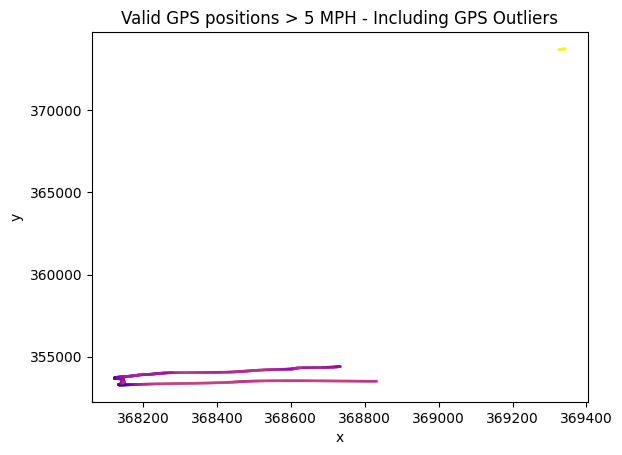

In [266]:
plt.close('all')
x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]

speeds = [pos['speed'] for pos in positions]

norm = plt.Normalize(min(speeds), max(speeds))
cmap = plt.cm.plasma

plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Valid GPS positions > {min_speed_filter} MPH - Including GPS Outliers')

Text(0.5, 1.0, 'Valid GPS positions > 5 MPH - Including GPS Outliers')

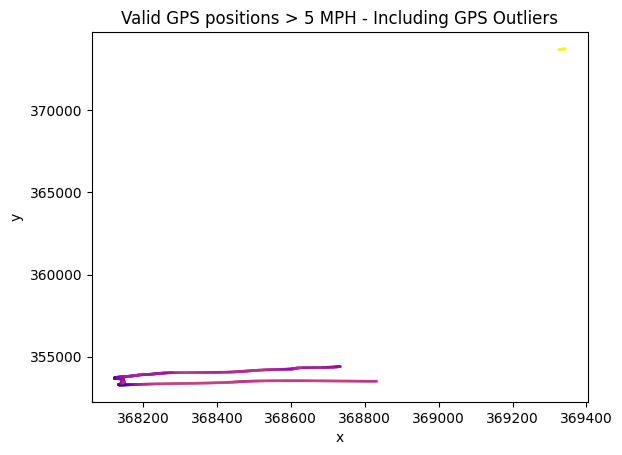

In [267]:
plt.close('all')

x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]

speeds = [pos['speed'] for pos in positions]

norm = plt.Normalize(min(speeds), max(speeds))
cmap = plt.cm.plasma

plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Valid GPS positions > {min_speed_filter} MPH - Including GPS Outliers')

### Remove outliers from our data

Median x: 368311.96335339634
Median y: 353642.1593489588


Text(0.5, 1.0, 'Valid GPS positions > 5 MPH')

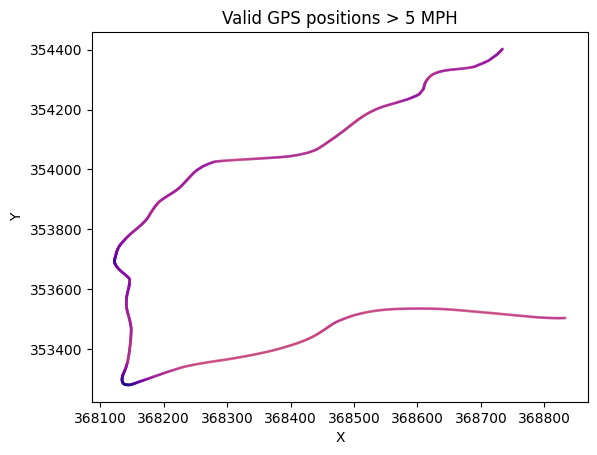

In [268]:
plt.close('all')

MIN_DISTANCE_OUTLIER_FILTER = 1000 # 1KM distance from the median

x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]

# calculate the median x and y
median_x = np.median(x)
median_y = np.median(y)
print(f'Median x: {median_x}')
print(f'Median y: {median_y}')

# filter out the points that are not within the MIN_DISTANCE_OUTLIER_FILTER
positions = [
    pos for pos in positions
        if abs(pos['x'] - median_x) < MIN_DISTANCE_OUTLIER_FILTER and 
            abs(pos['y'] - median_y) < MIN_DISTANCE_OUTLIER_FILTER
        ]

# plot the filtered points
x = [pos['x'] for pos in positions]
y = [pos['y'] for pos in positions]
speeds = [pos['speed'] for pos in positions]

plt.scatter(x, y, c=speeds, cmap=cmap, norm=norm, alpha=0.5, s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Valid GPS positions > {min_speed_filter} MPH')

In [269]:
# Get start and end time for frame estimation
positions = sorted(positions, key=lambda x: time_stamp_to_seconds(x['time']))
STARTING_TIME = time_stamp_to_seconds(positions[0]['time'])
print(f"Starting time: {STARTING_TIME}")

END_TIME = time_stamp_to_seconds(positions[-1]['time'])
print(f"Ending time: {END_TIME}")

Starting time: 53268.5
Ending time: 53448.6


### Remove invalid records and records under min_speed_filter mph

In [270]:
def filter_invalid_and_low_mph_records(positions):
    """Filter the data points to remove
        - invalid points
        - points less than min_speed_filter mph
        - points with the same latitude and longitude
    
    Args:
        positions (List[dict]): The list of positions
    
    Returns:
        List[dict]: The filtered list of positions
    """
    
    filtered_positions = []
    for i in range(len(positions)):
        if not positions[i]['valid']:
            continue

        if positions[i]['speed'] < min_speed_filter:
            continue

        filtered_positions.append(positions[i])
    return filtered_positions

In [271]:
positions = filter_invalid_and_low_mph_records(positions)
positions = sorted(positions, key=lambda x: time_stamp_to_seconds(x['time']))

print(f"{len(positions)} positions after filtering")
positions[:2]

1802 positions after filtering


[{'time': '144748.500',
  'valid': True,
  'latitude': 53.07784383333333,
  'longitude': -2.4666898333333336,
  'height': '36.3',
  'speed': 31.5026025,
  'x': 368833.07132119575,
  'y': 353503.77797975147},
 {'time': '144748.600',
  'valid': True,
  'latitude': 53.07784266666667,
  'longitude': -2.4667096666666666,
  'height': '36.3',
  'speed': 29.91797844,
  'x': 368831.74182129855,
  'y': 353503.65685044456}]

# Set accumulated distance in positions

In [272]:
def get_accumulated_distance(x_pos: list[float], y_pos: list[float]) -> list[float]:
    """Get the accumulated distance from x and y positions

    Args:
        x_pos (list[float]): x values
        y_pos (list[float]): y values

    Returns:
        list[float]: list of accumulated distances
    """

    distance = 0.0
    distances = [0.0]
    for i in range(1, len(x_pos)):
        dx = x_pos[i] - x_pos[i-1]
        dy = y_pos[i] - y_pos[i-1]
        distance += np.hypot(dx, dy)
        distances.append(distance)
    return distances

def set_accumulated_distance(positions: list[dict]) -> list[dict]:
    """Set the accumulated distance for the positions

    Args:
        positions (list[dict]): The list of positions

    Returns:
        list[dict]: The list of positions with accumulated distance
    """
    x_pos = [float(pos['x']) for pos in positions]
    y_pos = [float(pos['y']) for pos in positions]
    distances = get_accumulated_distance(x_pos, y_pos)
    for i in range(len(positions)):
        positions[i]['distance'] = distances[i]
    return positions

positions = set_accumulated_distance(positions)
positions[:2]

[{'time': '144748.500',
  'valid': True,
  'latitude': 53.07784383333333,
  'longitude': -2.4666898333333336,
  'height': '36.3',
  'speed': 31.5026025,
  'x': 368833.07132119575,
  'y': 353503.77797975147,
  'distance': 0.0},
 {'time': '144748.600',
  'valid': True,
  'latitude': 53.07784266666667,
  'longitude': -2.4667096666666666,
  'height': '36.3',
  'speed': 29.91797844,
  'x': 368831.74182129855,
  'y': 353503.65685044456,
  'distance': np.float64(1.335006474007011)}]

# Find bends

In [273]:
def apply_median_filter(records:list[float], size:int = 5):
    """Apply a median filter to a list

    Args:
        records (list[float]): The list of points
        size (int, optional): Kernel size. Defaults to 5.

    Returns:
        list[float]: The filtered points
    """

    temp = records.copy() # create a copy to avoid modifying the original list
    # slide a window of size 2*size+1 over the records
    for i in range(size, len(records)-size):
        temp[i] = np.median(records[i-size:i+size])
    return temp

In [274]:
def get_smoothed_sequence_angles(x_pos:list[float], y_pos:list[float], meters:int = 5) -> list[float]:
    """Get the smoothed sequence angles from x and y positions sequence

    Args:
        x_pos (list[float]): x positions
        y_pos (list[float]): y positions

    Returns:
        list[float]: The smoothed sequence angles
    """

    x_pos = apply_median_filter(x_pos, 5)
    y_pos = apply_median_filter(y_pos, 5)

    diff_x = np.diff(x_pos)
    diff_y = np.diff(y_pos)

    accumulated_distance = get_accumulated_distance(x_pos, y_pos)

    angles = []

    for i in range(1, len(accumulated_distance)):
        # find all positions within 5 meters before and after the current position
        current_distance = accumulated_distance[i]
        low_distance = max(0, current_distance - meters)
        high_distance = min(accumulated_distance[-1], current_distance + meters)

        low_index = np.searchsorted(accumulated_distance, low_distance, side='left')
        high_index = np.searchsorted(accumulated_distance, high_distance, side='right')
        high_index = min(high_index, len(accumulated_distance))

        # print(low_index, i, high_index)

        # Before vector (from low_index to i)
        before_vector = np.array([
            np.sum(diff_x[low_index:i]), 
            np.sum(diff_y[low_index:i])
        ])
        

        # After vector (from i to high_index)
        after_vector = np.array([
            np.sum(diff_x[i:high_index]), 
            np.sum(diff_y[i:high_index])
        ])
        
        # Check zero vectors
        if np.linalg.norm(before_vector) == 0 or np.linalg.norm(after_vector) == 0:
            angles.append(0.0)
            continue
        
        # Compute angle using vector operations
        dot = np.dot(before_vector, after_vector)
        cross = np.cross(before_vector, after_vector)  # Cross product magnitude (z-component)
        angle = np.arctan2(cross, dot)

        # flip sign to match intuitive angles
        angle = -angle
        
        angles.append(angle)

    angles_rad = np.array(angles)

    complex_angles = np.exp(1j * angles_rad)

    # smooth angles with gaussian filter
    gaussian = np.exp(-np.linspace(-2, 2, 5)**2)
    gaussian /= gaussian.sum()
    smoothed_complex = np.convolve(complex_angles, gaussian, mode='same')

    # Convert back to angles
    smoothed_angles = np.angle(smoothed_complex)
    smoothed_degrees = np.degrees(smoothed_angles)

    return smoothed_degrees

### Config parameters for bend ROI findings

In [275]:
lower_threshold = 5  # degrees
DB_SCAN_EPS = 10
DB_SCAN_MIN_SAMPLES = 3

/tmp/ipykernel_190597/4268488576.py:54: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(before_vector, after_vector)  # Cross product magnitude (z-component)


Found 1801 angles
[2.69300885 2.97755785 3.68726    4.08934031 4.53334266]


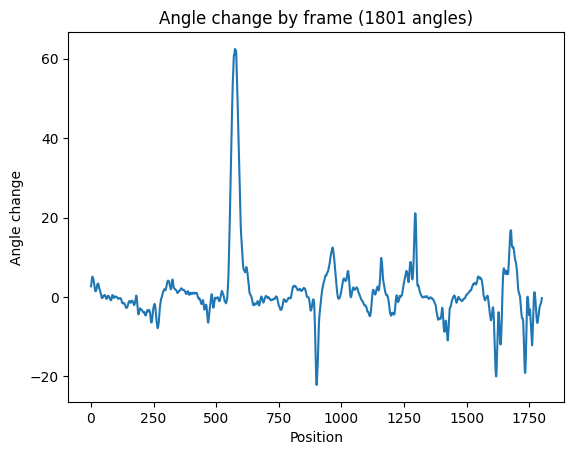

In [276]:
plt.close('all')

positions_ordered_by_time = sorted(positions, key=lambda x: time_stamp_to_seconds(x['time']))

x_pos = [pos['x'] for pos in positions_ordered_by_time]
y_pos = [pos['y'] for pos in positions_ordered_by_time]
speeds = [pos['speed'] for pos in positions_ordered_by_time]

angles = get_smoothed_sequence_angles(x_pos, y_pos, meters=10)

print(f"Found {len(angles)} angles")
print(angles[:5])

# angles_derivative = np.gradient(angles) # get the first derivative of the angles

angles_derivative = angles # get the first derivative of the angles

plot_angles = angles_derivative
plt.title(f"Angle change by frame ({len(angles)} angles)")
plt.xlabel("Position")
plt.ylabel("Angle change")
plt.plot(plot_angles)
plt.savefig(os.path.join(output_folder, "angle_graph.png"))

Found 1 bends
[ 5.01806839  5.10800946 -5.42292211 -6.09517195 -6.38087501]
Found 17 bends after clustering


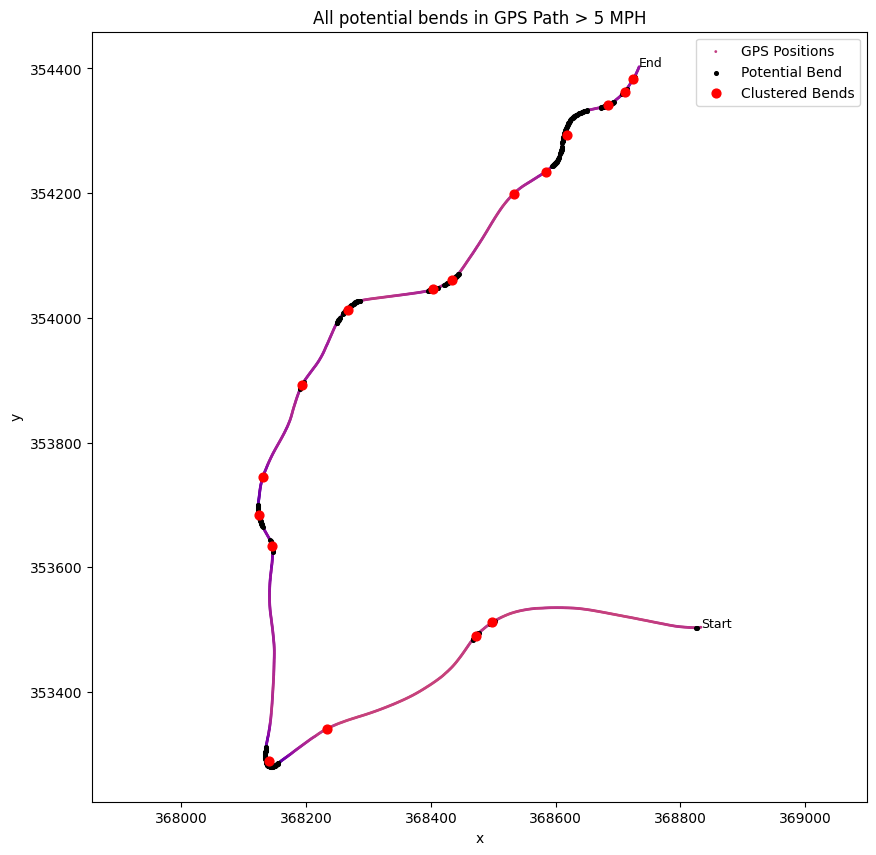

In [277]:
plt.close('all')

# bends above the threshold
bends = np.where(np.abs(angles_derivative) > lower_threshold)

print(f"Found {len(bends)} bends")
print(angles_derivative[bends][:5])

# cluster bends
bends_positions = np.array(list(zip(x_pos, y_pos)))[bends]

temp_store_bends = bends_positions.copy() # Store the potential bends for plotting later

# bends = cluster.vq.kmeans(bends_positions, )[0] # not applicable since we need to know K
# Apply DBSCAN clustering (automatic K)
if len(bends_positions) > 1:
    dbscan = DBSCAN(eps=DB_SCAN_EPS, min_samples=DB_SCAN_MIN_SAMPLES, metric="euclidean")  # Adjust eps based on your GPS resolution
    labels = dbscan.fit_predict(bends_positions)
    
    # Get unique cluster centers
    unique_labels = set(labels)
    cluster_centers = np.array([bends_positions[labels == i].mean(axis=0) for i in unique_labels if i != -1])  # Ignore noise
else:
    cluster_centers = bends_positions  # If no clustering is needed, keep original bends

print(f"Found {len(cluster_centers)} bends after clustering")

plt.scatter(
    x_pos,
    y_pos,
    c=[cmap(norm(float(s))) for s in speeds],
    s=1,
    label='GPS Positions'
)

# add start and end points TEXT LABEL
plt.text(
    x_pos[0],
    y_pos[0],
    'Start',
    fontsize=9,
    color='black'
)

plt.text(
    x_pos[-1],
    y_pos[-1],
    'End',
    fontsize=9,
    color='black'
)

plt.scatter(
    temp_store_bends[:, 0],
    temp_store_bends[:, 1],
    color='black',
    label='Potential Bend',
    s=7
)

if len(cluster_centers) > 0:
    plt.scatter(
        cluster_centers[:,0],
        cluster_centers[:,1],
        color='red',
        label='Clustered Bends',
        s=40
    )
else:
    plt.legend(["GPS Positions", "Potential Bend"])

# set size
plt.gcf().set_size_inches(10, 10)
plt.title(f"All potential bends in GPS Path > {min_speed_filter} MPH")
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
plt.axis('equal')


plt.savefig(os.path.join(output_folder, "bends.png"))

In [278]:
print(f"total of {len(cluster_centers)} potential bend clusters found")
cluster_centers

total of 17 potential bend clusters found


array([[368498.33809172, 353511.6443848 ],
       [368471.76320071, 353489.6574762 ],
       [368232.89884151, 353340.90297517],
       [368140.01090343, 353290.0495607 ],
       [368145.22356529, 353634.6059591 ],
       [368124.72302905, 353683.22850603],
       [368130.59911224, 353745.21442306],
       [368192.87302006, 353891.56641218],
       [368266.63224704, 354012.58468372],
       [368402.91252077, 354045.49273096],
       [368433.34649088, 354060.96505659],
       [368532.76834085, 354199.11793152],
       [368584.42744189, 354234.60588393],
       [368618.3728899 , 354293.78350487],
       [368683.2452595 , 354341.01216537],
       [368710.74621491, 354362.6046921 ],
       [368724.85803898, 354383.21602877]])

### Estimate relevant frames

In [279]:
def time_stamp_to_frame_number(time_stamp:str, STARTING_TIME:int = STARTING_TIME, END_TIME:int = END_TIME, total_frames:int = total_frames):
    """Estimate frame number using the timestamp

    Args:
        time_stamp (str): The time stamp to convert
        STARTING_TIME (int, optional): video starting time stamp. Defaults to STARTING_TIME.
        END_TIME (int, optional): video ending timestamp. Defaults to END_TIME.
        total_frames (int, optional): total number of frames. Defaults to total_frames.

    Returns:
        int: frame number
    """
    # calculate the difference between the time stamp and the starting time
    diff = time_stamp_to_seconds(time_stamp) - STARTING_TIME

    total_time = END_TIME - STARTING_TIME

    # print(f"diff: {diff}, toal_time: {total_time}")

    if total_time <= 0:
        return 0
    
    # estimate the frame number
    # predict_frame_number = int((diff / total_time) * total_frames)
    
    # return predict_frame_number
 
    closest_frame = min(frame_times, key=lambda x: abs(x - diff))
    return frame_times.index(closest_frame)

def get_closest_position_based_on_lat_lon(x:float, y:float, positions:list[dict]):
    """Get the closest position based on x and y

    Args:
        lat (float): x
        lon (float): y
        positions (list[dict], optional): list of all positions. Defaults to positions.

    Returns:
        dict: The closest position
    """
    min_distance = float('inf')
    closest_position = None

    # print(positions[:5])

    for position in positions:
        p_x = position['x']
        p_y = position['y']
        distance = np.sqrt((p_x - x)**2 + (p_y - y)**2)

        if distance < min_distance:
            min_distance = distance
            closest_position = position

    return closest_position


def get_frame_number_based_on_bend_x_y(cluster_centers:list[list[float]], positions:list[dict] = positions):
    """Get the frame number based on the bend x and y for each cluster center

    Args:
        cluster_centers (list[list[float]]): list of cluster centers
        positions (list[dict], optional): list of considered positions. Defaults to positions.

    Returns:
        list[int]: list of frame numbers
    """
    frame_numbers = []
    for bend in cluster_centers:
        closest_position = get_closest_position_based_on_lat_lon(bend[0], bend[1], positions)
        frame_number = time_stamp_to_frame_number(closest_position['time'])
        # print(f"frame_number: {frame_number}")
        frame_numbers.append(frame_number)

    return frame_numbers

In [280]:
frame_numbers = get_frame_number_based_on_bend_x_y(cluster_centers)

print(f"Estimated frame numbers: {frame_numbers}")

Estimated frame numbers: [722, 800, 1400, 1780, 2703, 2862, 3072, 3477, 3833, 4166, 4247, 4633, 4786, 4966, 5182, 5275, 5341]


### Output images of estimated frames

Total frames: 5400


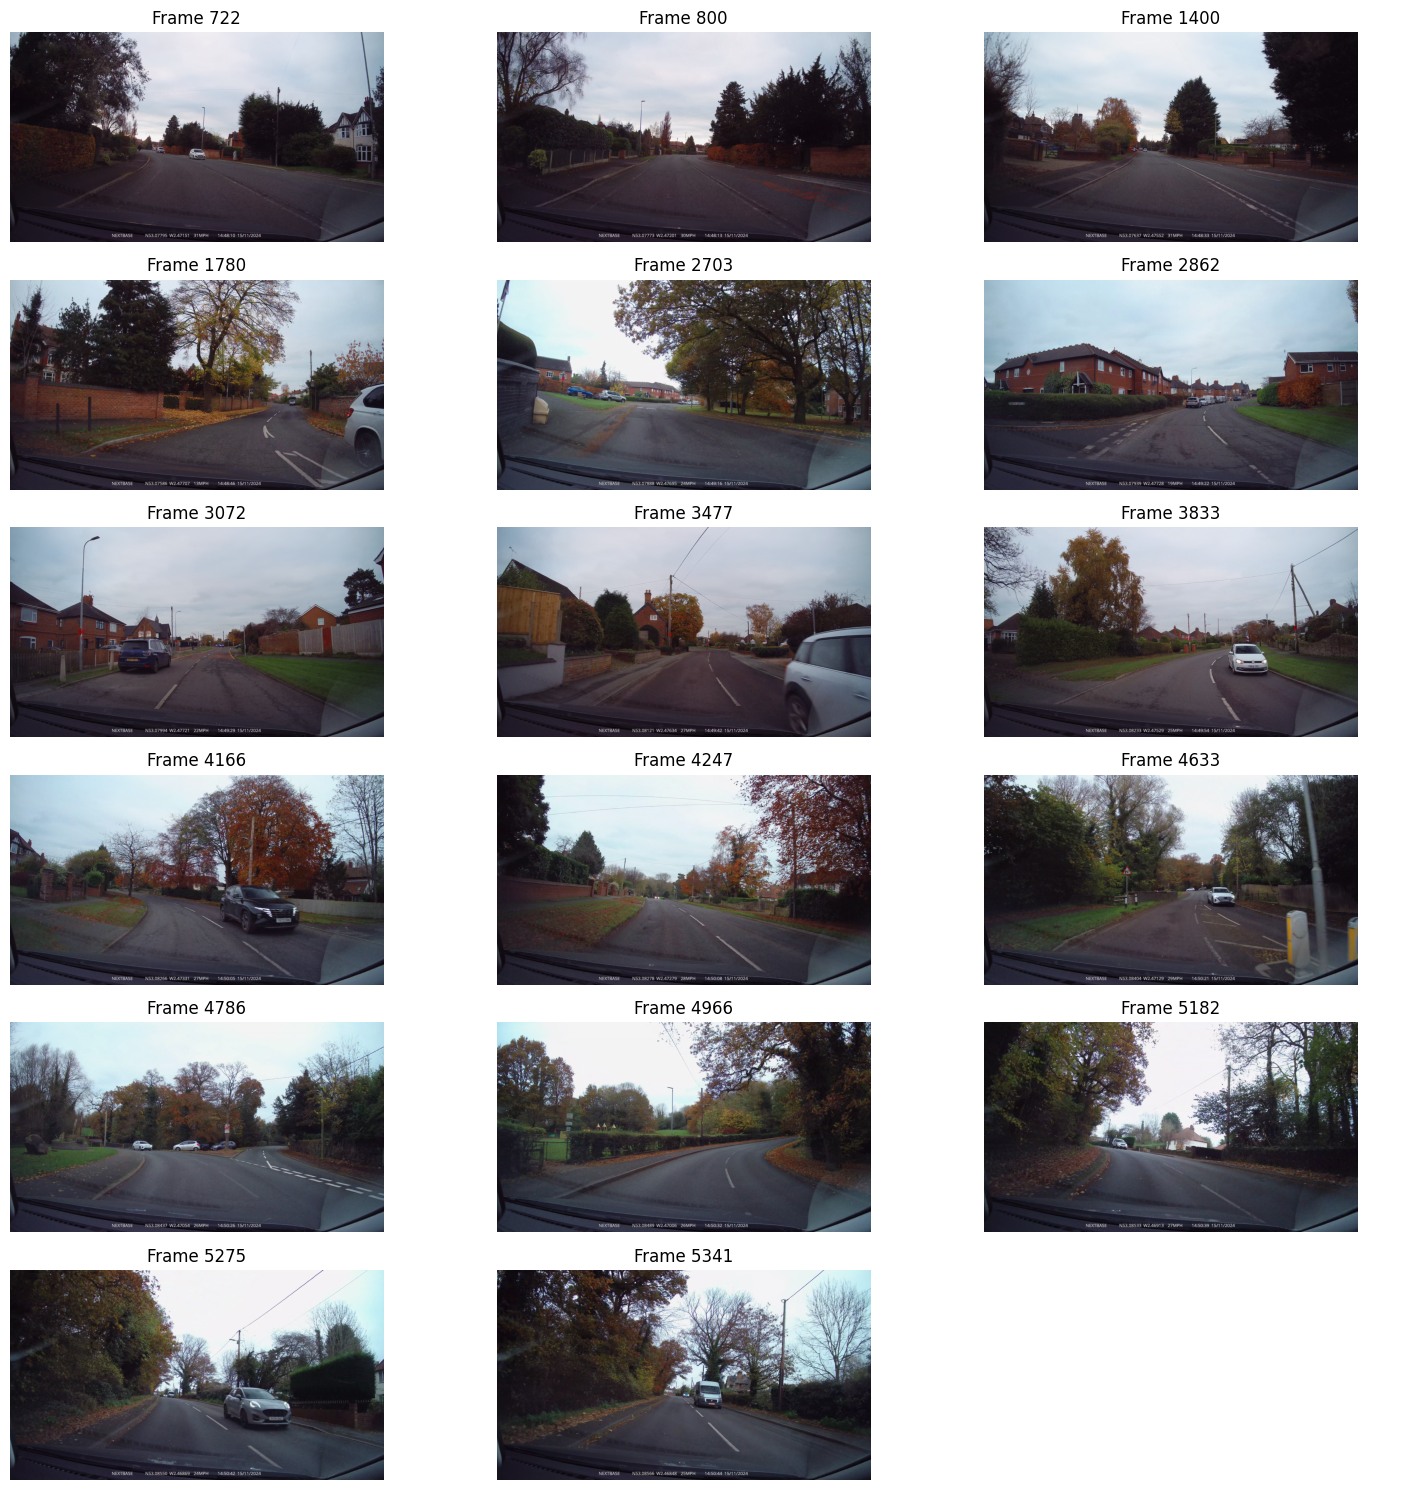

In [281]:
frame_numbers = sorted(frame_numbers)

def print_frames(frame_numbers:list[int], file_path:str = file_path):
    plt.close('all')
    
    frames = []

    cap = cv2.VideoCapture(file_path, cv2.CAP_FFMPEG)

    for frame_number in frame_numbers:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
        else:
            print(f"Warning: Could not read frame {frame_number}")
    
    cap.release()
    
    if frames:
        n_frames = len(frames)
        n_cols = min(3, n_frames)
        n_rows = math.ceil(n_frames / n_cols)
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        for i, frame in enumerate(frames):
            axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            axes[i].axis('off')
            axes[i].set_title(f"Frame {frame_numbers[i]}")

        for i in range(n_frames, len(axes)): # clear the rest of the axes
            axes[i].axis('off')          

        plt.tight_layout()
    else:
        print("No frames to display")

    return frames

frames = print_frames(frame_numbers)

print(f"Total frames: {total_frames}")

In [282]:
for i, frame in enumerate(frames):
    output_file = os.path.join(output_folder, f"bend_{i}.jpg")
    cv2.imwrite(output_file, frame)


# Calculate Bends in ROI

In [283]:
def plot_bend(bend_name:str, cluster_center:list[float], points:list[dict], focused_positions:list[dict]=None):
    """Plot the bend with the given name and points

    Args:
        bend_name (str): plot title
        points (list[dict]): list of points
    """
    plt.close('all')
    points = sorted(points, key=lambda x: time_stamp_to_seconds(x['time']))

    x = [float(pos['x']) for pos in points]
    y = [float(pos['y']) for pos in points]
    
    plt.scatter(x, y, s=1)
    plt.scatter(cluster_center[0], cluster_center[1], color='red', s=40)
    if not focused_positions is None:
        focused_x = [float(pos['x']) for pos in focused_positions]
        focused_y = [float(pos['y']) for pos in focused_positions]
        plt.scatter(focused_x, focused_y, color='green', s=40)

    plt.text(
        x[0],
        y[0],
        'Segment Start',
        fontsize=9,
        color='black'
    )

    plt.text(
        x[-1],
        y[-1],
        'Segment End',
        fontsize=9,
        color='black'
    )

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(bend_name)
    plt.axis('equal')

    plt.savefig(os.path.join(output_folder, f"{bend_name}.png"))

    if args.f:
        plt.show()
    else:
        plt.close('all')

## Find closest position entry to point of interest

In [284]:
def closest_point_to_x_y(x:float, y:float, positions:list[dict]):
    """Get the closest point to x, y

    Args:
        x (float): The x coordinate
        y (float): The y coordinate
        positions (list[dict]): The list of positions

    Returns:
        dict: The closest point
    """
    min_distance = float('inf')
    closest_point = None
    for position in positions:
        distance = np.sqrt((x - position['x'])**2 + (y - position['y'])**2)
        if distance < min_distance:
            min_distance = distance
            closest_point = position
    return closest_point

def get_points_near_a_cluster_estimated_center(
        cluster_center:list[float],
        positions:list[dict],
        distance_threshold:float = 100):
    """Get the points near a cluster estimated center

    Args:
        cluster_center (list[float]): list of estimated centers
        positions (list[dict]): list of gps positions
        distance_threshold (float, optional): The distance threshold. Defaults to 100.

    Returns:
        list[dict]: The positions within the distance threshold
    """
    closest_point = closest_point_to_x_y(cluster_center[0], cluster_center[1], positions)
    closest_point_accumulated_distance = closest_point['distance']
    points = [closest_point]

    print(f"Closest point: {closest_point}")
    print(f"Closest point accumulated distance: {closest_point_accumulated_distance}")

    for position in positions:
        if abs(position['distance'] - closest_point_accumulated_distance) < distance_threshold:
            points.append(position)

    points = sorted(points, key=lambda x: time_stamp_to_seconds(x['time']))

    return points

## find first curve of a series of points

In [317]:
def find_first_bend_from_series(points:list[dict], min_degree_threshold:float = 2):
    """Find the initial bend from the series of points

    Args:
        points (list[dict]): list of points

    Returns:
        list[float]: The initial bend
    """
    points = sorted(points, key=lambda x: time_stamp_to_seconds(x['time']))

    x = [pos['x'] for pos in points]
    y = [pos['y'] for pos in points]

    angles = get_smoothed_sequence_angles(x, y, meters=7)

    print(angles[:5])

    # set threshold to largest 20% of angles
    # abs_angles = np.abs(angles)
    # abs_angles = np.sort(abs_angles)
    # sum_angles = np.sum(abs_angles)
    # auto_degree_threshold = 0
    # accumulated_sum = 0
    # for i in range(len(abs_angles)):
    #     accumulated_sum += abs_angles[i]
    #     if accumulated_sum > sum_angles * 0.7:
    #         auto_degree_threshold = abs_angles[i]
    #         break

    abs_angles = np.abs(angles)
    auto_degree_threshold = np.percentile(abs_angles, 85)

    print("automatic threshold:", auto_degree_threshold)

    min_degree_threshold = max(min_degree_threshold, auto_degree_threshold)

    first_bend_found = False
    first_bend_sign = None

    tolerance = 3

    first_bend_positions = []
    first_bend_angles_for_direction_label = []

    for i in range(10, len(angles)):
        sign = np.sign(angles[i])
        if abs(angles[i]) > min_degree_threshold:
            if not first_bend_found:
                first_bend_positions.append(points[i])
                first_bend_angles_for_direction_label.append(angles[i])
                first_bend_found = True
                first_bend_sign = sign
            elif first_bend_sign == sign:
                first_bend_positions.append(points[i])
                first_bend_angles_for_direction_label.append(angles[i])
            
            continue

        if first_bend_found and first_bend_sign != sign:
            if tolerance <= 0:
                break
            tolerance -= 1  

    if not first_bend_found or len(first_bend_positions) < 3:
        print("No first bend found")
        return None, None, None

    # determine if the first bend is a left or right bend
    first_bend_sign = np.sign(np.mean(first_bend_angles_for_direction_label))
    average_bend_angle = np.mean(first_bend_angles_for_direction_label)

    print("average steepness on bend:", average_bend_angle)
    
    if first_bend_sign < 0:
        print("First bend is a left bend")
    else:
        print("First bend is a right bend")

    return first_bend_positions, first_bend_sign, average_bend_angle

Closest point: {'time': '144812.600', 'valid': True, 'latitude': 53.07789866666667, 'longitude': -2.4716786666666666, 'height': '40.6', 'speed': 31.68442574, 'x': 368498.9047407678, 'y': 353512.0671119724, 'distance': np.float64(341.0778021940647)}
Closest point accumulated distance: 341.0778021940647
[-0.91546288 -0.8884467  -1.0876937  -1.15419522 -1.18179888]
automatic threshold: 3.5947079113008242
average steepness on bend: -4.8003112949544935
First bend is a left bend
Start of focused points: 566


/tmp/ipykernel_190597/4268488576.py:54: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(before_vector, after_vector)  # Cross product magnitude (z-component)


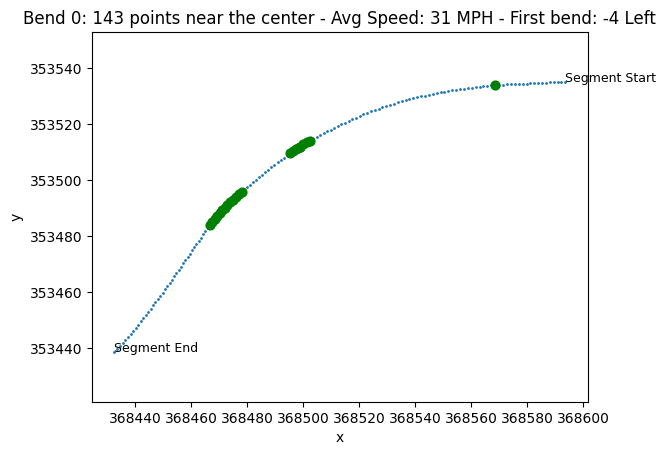

start_of_focused_points_position_accumulated_distance: 267.25414392607775
Closest point: {'time': '144815.200', 'valid': True, 'latitude': 53.077692166666665, 'longitude': -2.4720903333333335, 'height': '42.6', 'speed': 30.72122288, 'x': 368471.1754248736, 'y': 353489.27660847595, 'distance': np.float64(377.03385160149793)}
Closest point accumulated distance: 377.03385160149793
[-2.02659429 -1.84250038 -1.90587963 -2.06902344 -1.98120632]
automatic threshold: 3.603597695808276
average steepness on bend: -4.91441047421292
First bend is a left bend
Start of focused points: 713


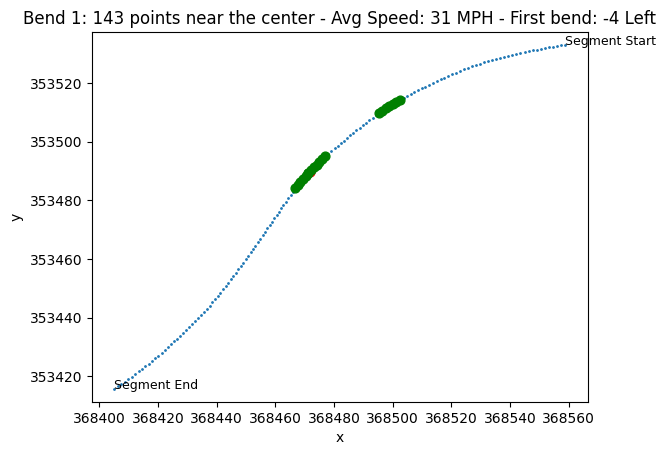

start_of_focused_points_position_accumulated_distance: 336.85764232616737
Closest point: {'time': '144835.200', 'valid': True, 'latitude': 53.0763475, 'longitude': -2.475624, 'height': '44.3', 'speed': 32.49342408, 'x': 368233.45761802833, 'y': 353341.25464731856, 'distance': np.float64(664.4502322518978)}
Closest point accumulated distance: 664.4502322518978
[0.15703938 0.37015431 0.41848195 0.47202057 0.5118599 ]
automatic threshold: 1.7703686145519735
average steepness on bend: -3.413631776147759
First bend is a left bend
Start of focused points: 1352


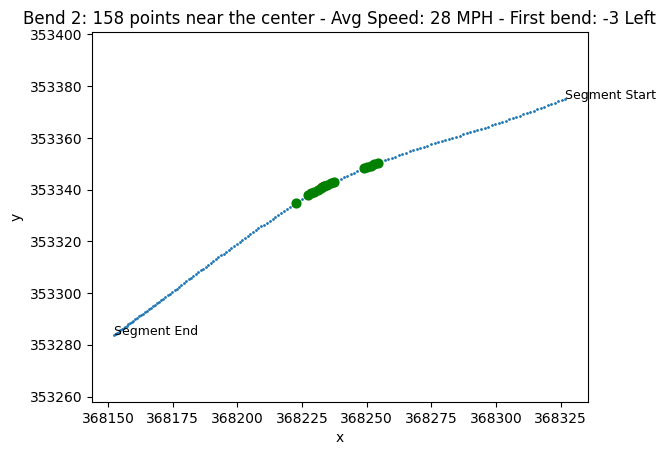

start_of_focused_points_position_accumulated_distance: 641.6546195903991
Closest point: {'time': '144847.900', 'valid': True, 'latitude': 53.07587133333333, 'longitude': -2.4770841666666668, 'height': '43.3', 'speed': 14.622961459999999, 'x': 368135.2834708231, 'y': 353288.9338307462, 'distance': np.float64(786.859443137071)}
Closest point accumulated distance: 786.859443137071
[-2.19672088 -2.53466024 -2.61528688 -2.8859235  -2.95325411]
automatic threshold: 22.709515632579723
average steepness on bend: 39.40210971280583
First bend is a right bend
Start of focused points: 1675


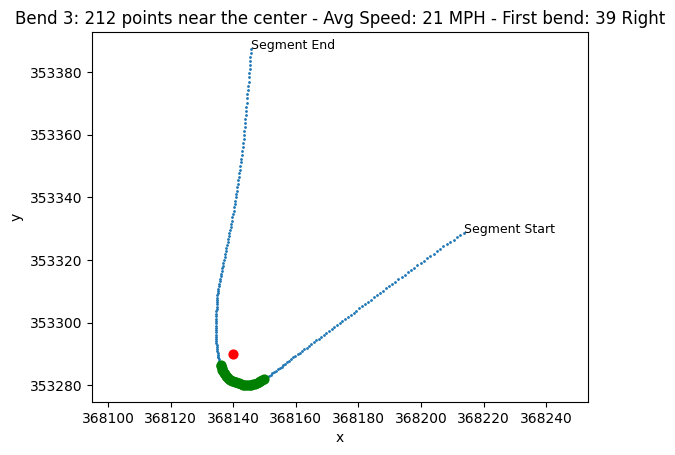

start_of_focused_points_position_accumulated_distance: 767.1469428477391
Closest point: {'time': '144918.700', 'valid': True, 'latitude': 53.07897766666667, 'longitude': -2.4769579999999998, 'height': '44.2', 'speed': 22.93619618, 'x': 368146.0369291725, 'y': 353634.44293793984, 'distance': np.float64(1134.019021031603)}
Closest point accumulated distance: 1134.019021031603
[1.0561992  1.3390751  1.73964741 1.83922607 1.81574338]
automatic threshold: 6.273422811644629
average steepness on bend: -14.090376579638201
First bend is a left bend
Start of focused points: 2685


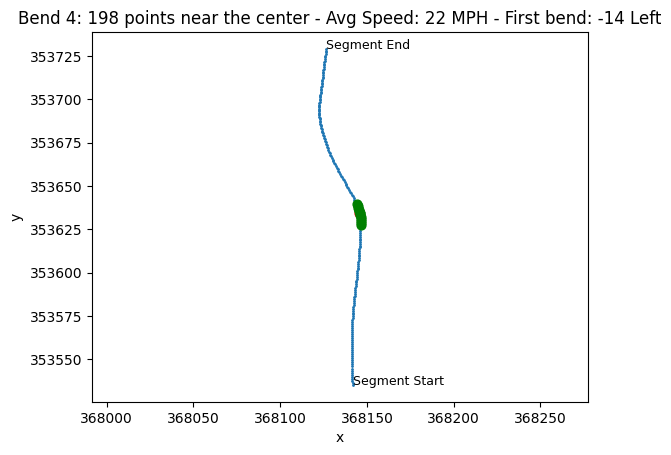

start_of_focused_points_position_accumulated_distance: 1127.1018741897162
Closest point: {'time': '144924.000', 'valid': True, 'latitude': 53.079410833333334, 'longitude': -2.4772928333333333, 'height': '43.2', 'speed': 18.85898264, 'x': 368123.92782347417, 'y': 353682.7801785151, 'distance': np.float64(1187.3623640628134)}
Closest point accumulated distance: 1187.3623640628134
[-0.67666034 -0.52329874 -0.54644294 -0.49177039 -0.39182396]
automatic threshold: 6.234924897107086
average steepness on bend: -13.640468621072904
First bend is a left bend
Start of focused points: 2685


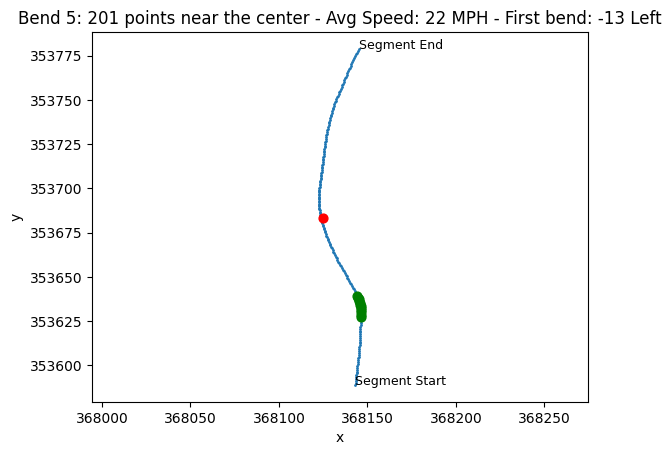

start_of_focused_points_position_accumulated_distance: 1127.1018741897162
Closest point: {'time': '144931.000', 'valid': True, 'latitude': 53.07996816666667, 'longitude': -2.4772023333333335, 'height': '42.3', 'speed': 22.93274384, 'x': 368130.40335771523, 'y': 353744.74059520994, 'distance': np.float64(1250.160459207306)}
Closest point accumulated distance: 1250.160459207306
[0.09602248 0.1475896  0.23399227 0.4766861  0.70335756]
automatic threshold: 5.169126973499286
average steepness on bend: 7.194526323865111
First bend is a right bend
Start of focused points: 2847


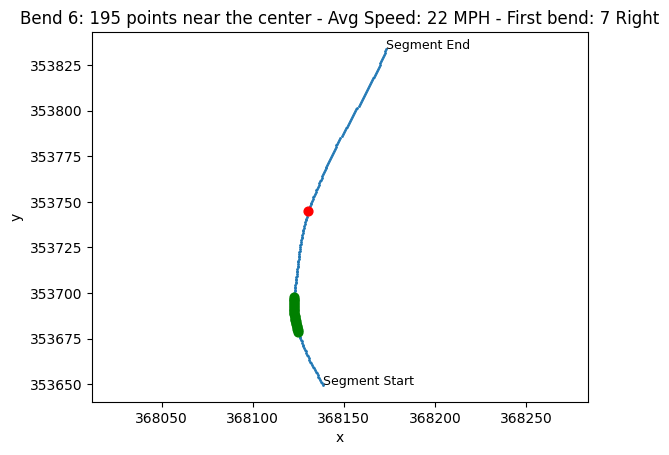

start_of_focused_points_position_accumulated_distance: 1183.0583461390156
Closest point: {'time': '144944.500', 'valid': True, 'latitude': 53.08129266666667, 'longitude': -2.4762866666666667, 'height': '42.4', 'speed': 24.874109699999995, 'x': 368192.7215098999, 'y': 353891.6769841739, 'distance': np.float64(1410.2590000820894)}
Closest point accumulated distance: 1410.2590000820894
[-0.63667763 -0.51778024 -0.45088479 -0.55801252 -0.65196288]
automatic threshold: 3.0297502396613547
average steepness on bend: -3.4872845401130017
First bend is a left bend
Start of focused points: 3306


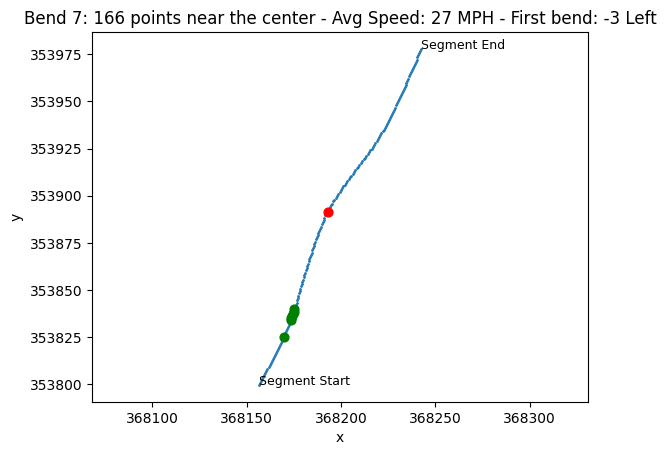

start_of_focused_points_position_accumulated_distance: 1339.689788807808
Closest point: {'time': '144956.400', 'valid': True, 'latitude': 53.082392166666665, 'longitude': -2.4752183333333333, 'height': '37.2', 'speed': 25.98691396, 'x': 368265.0959948308, 'y': 354013.5160939108, 'distance': np.float64(1552.709776029301)}
Closest point accumulated distance: 1552.709776029301
[-1.63720944 -2.58041753 -3.24043578 -3.47069697 -3.16410618]
automatic threshold: 4.4534086900246
average steepness on bend: 9.078461031211662
First bend is a right bend
Start of focused points: 3773


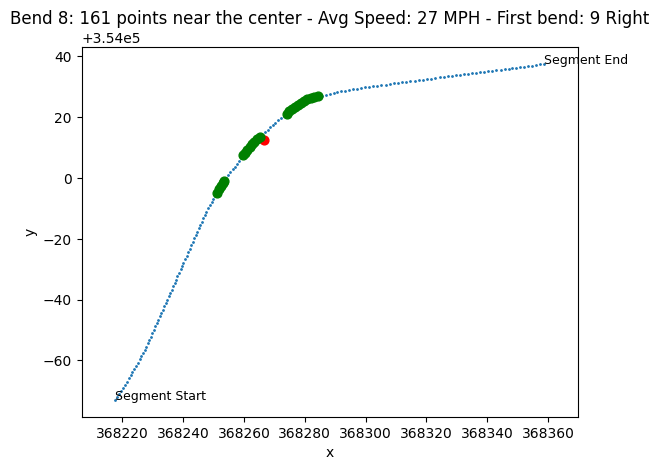

start_of_focused_points_position_accumulated_distance: 1529.6226335145075
Closest point: {'time': '145007.500', 'valid': True, 'latitude': 53.082685166666664, 'longitude': -2.4731725, 'height': '37.8', 'speed': 27.965104779999997, 'x': 368402.3492037547, 'y': 354045.2037555356, 'distance': np.float64(1695.9523281034135)}
Closest point accumulated distance: 1695.9523281034135
[-0.03270065  0.17869633  0.24514337  0.26868956  0.33606264]
automatic threshold: 4.076419469445463
average steepness on bend: -6.18961689279601
First bend is a left bend
Start of focused points: 4181


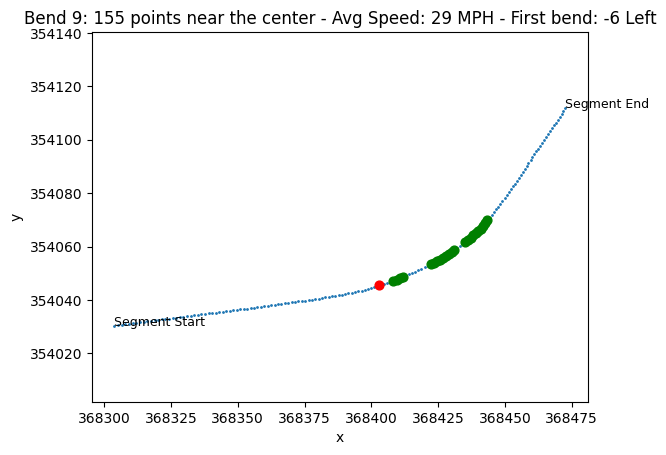

start_of_focused_points_position_accumulated_distance: 1702.191020173892
Closest point: {'time': '145010.200', 'valid': True, 'latitude': 53.082822166666666, 'longitude': -2.4727145, 'height': '36.4', 'speed': 28.56926428, 'x': 368433.12820705306, 'y': 354060.24181946495, 'distance': np.float64(1730.392454990905)}
Closest point accumulated distance: 1730.392454990905
[-0.39503403 -0.09075789  0.10910599  0.02075779 -0.06214604]
automatic threshold: 4.065268501419941
average steepness on bend: -6.0985642696100655
First bend is a left bend
Start of focused points: 4154


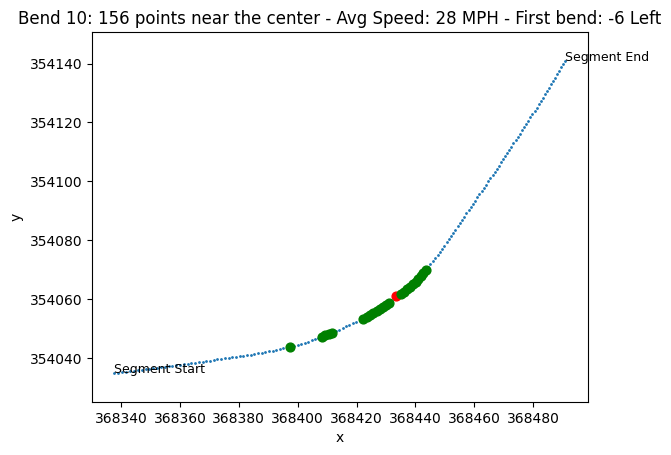

start_of_focused_points_position_accumulated_distance: 1690.959225930945
Closest point: {'time': '145023.100', 'valid': True, 'latitude': 53.0840765, 'longitude': -2.4712406666666666, 'height': '30.8', 'speed': 28.976640399999997, 'x': 368532.7684222919, 'y': 354199.13029207825, 'distance': np.float64(1902.0209773300346)}
Closest point accumulated distance: 1902.0209773300346
[ 0.04442127  0.21684578 -0.02212182 -0.14154872 -0.18471391]
automatic threshold: 3.965246673501137
average steepness on bend: 4.043825158931239
First bend is a right bend
Start of focused points: 4633


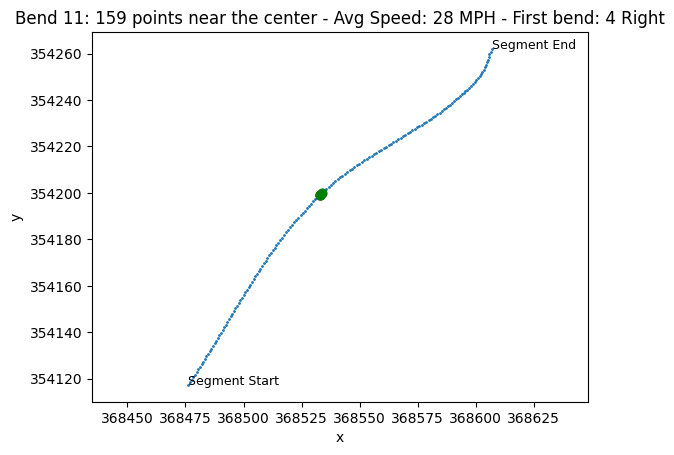

start_of_focused_points_position_accumulated_distance: 1902.0209773300346
Closest point: {'time': '145028.200', 'valid': True, 'latitude': 53.08439833333333, 'longitude': -2.4704728333333335, 'height': '30.7', 'speed': 25.56112536, 'x': 368584.4340671523, 'y': 354234.59471518855, 'distance': np.float64(1964.8035984214375)}
Closest point accumulated distance: 1964.8035984214375
[1.51714635 1.28921748 1.49798918 1.80557562 1.93057722]
automatic threshold: 7.853686910853517
average steepness on bend: -11.696337198272195
First bend is a left bend
Start of focused points: 4828


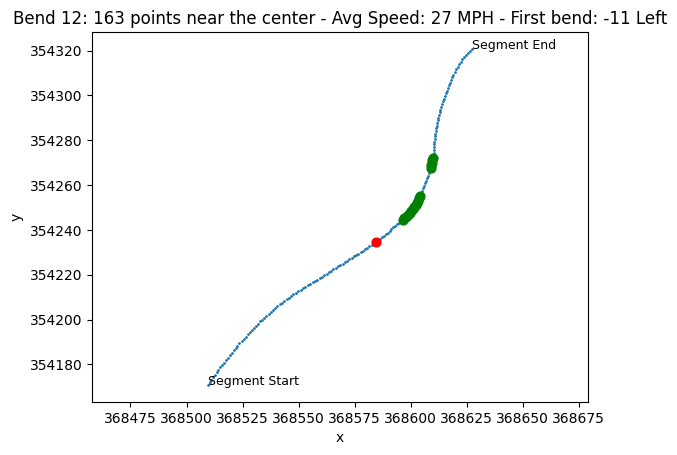

start_of_focused_points_position_accumulated_distance: 1980.3753349479327
Closest point: {'time': '145034.200', 'valid': True, 'latitude': 53.084942166666664, 'longitude': -2.4700423333333332, 'height': '30.4', 'speed': 28.5048206, 'x': 368613.666345482, 'y': 354294.9044510776, 'distance': np.float64(2034.8207870142833)}
Closest point accumulated distance: 2034.8207870142833
[ 0.24796876 -0.06378408 -0.06109681  0.16612004  0.12991896]
automatic threshold: 9.560024268396901
average steepness on bend: -13.678043249369352
First bend is a left bend
Start of focused points: 4831


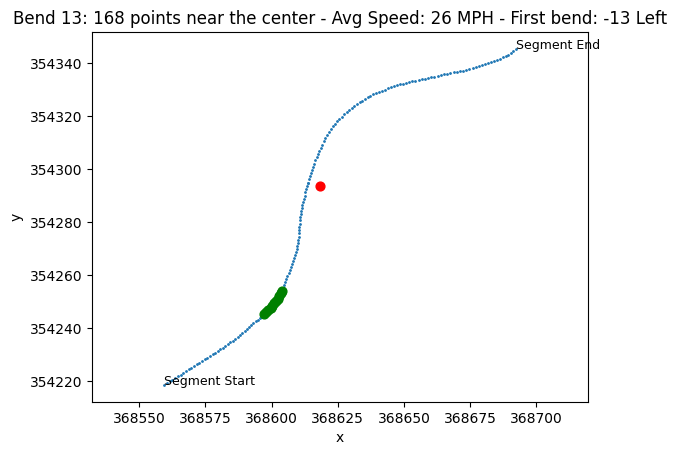

start_of_focused_points_position_accumulated_distance: 1981.4610980069642
Closest point: {'time': '145041.400', 'valid': True, 'latitude': 53.08535533333333, 'longitude': -2.4690115, 'height': '34.6', 'speed': 27.04448078, 'x': 368683.0124952431, 'y': 354340.41478752013, 'distance': np.float64(2124.234513695122)}
Closest point accumulated distance: 2124.234513695122
[3.63059014 2.49023663 2.51148077 2.70413068 3.14980552]
automatic threshold: 8.946623407695288
average steepness on bend: 11.776686234209942
First bend is a right bend
Start of focused points: 5008


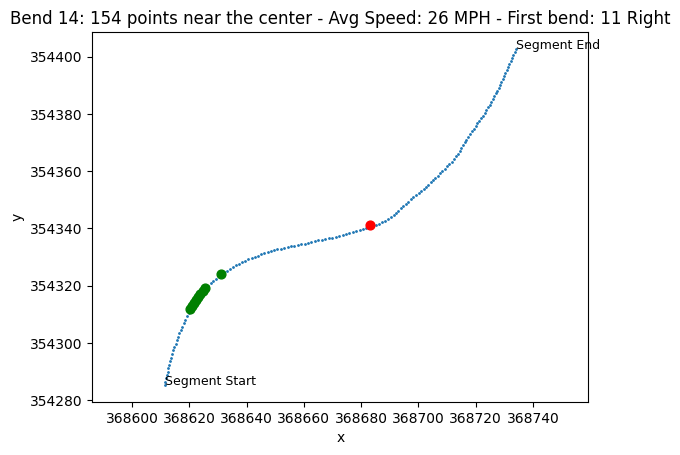

start_of_focused_points_position_accumulated_distance: 2052.9102636587536
Closest point: {'time': '145044.500', 'valid': True, 'latitude': 53.0855555, 'longitude': -2.4685981666666668, 'height': '35.5', 'speed': 25.525451179999997, 'x': 368710.8429675606, 'y': 354362.501236113, 'distance': np.float64(2160.1049058325393)}
Closest point accumulated distance: 2160.1049058325393
[8.17938373 5.9895416  6.02353056 7.49965649 8.09181847]
automatic threshold: 8.598429557884776
average steepness on bend: -13.470052486049617
First bend is a left bend
Start of focused points: 5185


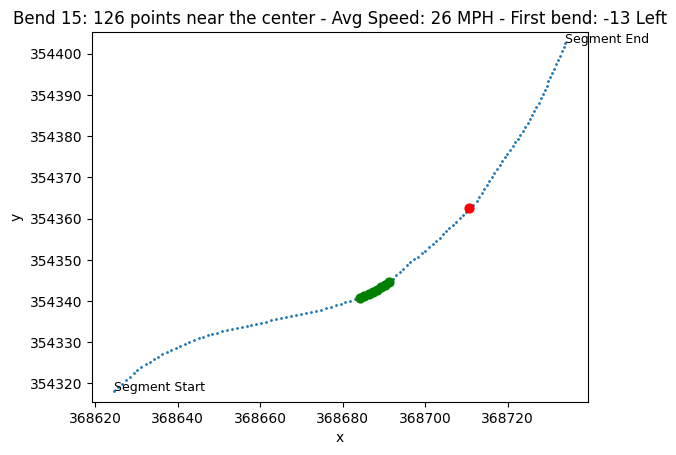

start_of_focused_points_position_accumulated_distance: 2125.421437918448
Closest point: {'time': '145046.700', 'valid': True, 'latitude': 53.0857425, 'longitude': -2.4683905, 'height': '35.9', 'speed': 25.11462272, 'x': 368724.88832198357, 'y': 354383.21318177023, 'distance': np.float64(2185.18956011728)}
Closest point accumulated distance: 2185.18956011728
[1.61416033 2.71021984 2.97913107 2.62533128 2.33105494]
automatic threshold: 6.9916211964421136
average steepness on bend: -12.925423114375498
First bend is a left bend
Start of focused points: 5182


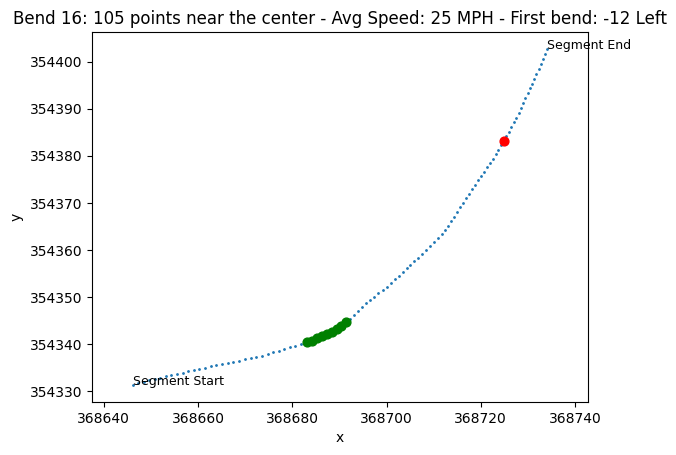

start_of_focused_points_position_accumulated_distance: 2124.234513695122


In [318]:
bends_for_curve_fitting = []

for i, bend in enumerate(cluster_centers):
    records = get_points_near_a_cluster_estimated_center(bend, positions, distance_threshold=100)
    avg_speed = np.mean([float(pos['speed']) for pos in records])

    focused_points, first_bend_sign, average_bend_angle = find_first_bend_from_series(records, min_degree_threshold=2)
    
    if focused_points is None:
        name = f"Bend {i}: {len(records)} points near the center - Avg Speed: {int(avg_speed)} MPH - No first bend found"
    else:
        name = f"Bend {i}: {len(records)} points near the center - Avg Speed: {int(avg_speed)} MPH - First bend: {int(average_bend_angle)} {"Left" if first_bend_sign < 0 else "Right"}"

    
    if focused_points is not None:
        focused_points = sorted(focused_points, key=lambda x: time_stamp_to_seconds(x['time']))
        start_of_focused_points = focused_points[0]
        start_of_focused_points_frame = time_stamp_to_frame_number(start_of_focused_points['time'])
        print(f"Start of focused points: {start_of_focused_points_frame}")

    plot_bend(name, bend, records, focused_points)
    if len(records) > 0 and focused_points is not None:
        start_of_focused_points = focused_points[0]
        print(f"start_of_focused_points_position_accumulated_distance: {start_of_focused_points['distance']}")

        bends_for_curve_fitting.append({
            "bend": bend,
            "focused_points": focused_points,
            "Estimated_start_frame": start_of_focused_points_frame,
            "first_bend_sign": "Left" if first_bend_sign < 0 else "Right",
            "average_bend_angle": average_bend_angle,
            "avg_speed": avg_speed,
            "start_of_focused_points_position_accumulated_distance": start_of_focused_points['distance']
        })

# Kasa Iterative Curve Fitting

I decided to use the mean angle on the bend due to time constraints, but did run some experiments with online sourced code and the results were good. I will talk about this approach but since I did not write my own code for this I will not include it in the final submission.

# Organise and Filter CSV

In [319]:
columns = ["frame", "bend_direction", "avg_speed", "start_of_focused_points_position_accumulated_distance", "average_bend_angle"]
data = []

for bend in bends_for_curve_fitting:
    data.append([bend['Estimated_start_frame'], bend['first_bend_sign'],bend['avg_speed'], bend['start_of_focused_points_position_accumulated_distance'], bend['average_bend_angle']])

df = pd.DataFrame(data, columns=columns)

df

frame bend_direction  avg_speed  \
0     566           Left  31.453393   
1     713           Left  31.672427   
2    1352           Left  28.521587   
3    1675          Right  21.143569   
4    2685           Left  22.689075   
5    2685           Left  22.312571   
6    2847          Right  22.980357   
7    3306           Left  27.079212   
8    3773          Right  27.766434   
9    4181           Left  29.069468   
10   4154           Left  28.902740   
11   4633          Right  28.296233   
12   4828           Left  27.676789   
13   4831           Left  26.846444   
14   5008          Right  26.536628   
15   5185           Left  26.084803   
16   5182           Left  25.890205   

    start_of_focused_points_position_accumulated_distance  average_bend_angle  
0                                          267.254144               -4.800311  
1                                          336.857642               -4.914410  
2                                          641.654620               -3.413632  
3                                          767.146943               39.402110  
4                                         1127.101874              -14.090377  
5                                         1127.101874              -13.640469  
6                                         1183.058346                7.194526  
7                                         1339.689789               -3.487285  
8                                         1529.622634                9.078461  
9                                         1702.191020               -6.189617  
10                                        1690.959226               -6.098564  
11                                        1902.020977                4.043825  
12                                        1980.375335              -11.696337  
13                                        1981.461098              -13.678043  
14                                        2052.910264               11.776686  
15                                        2125.421438              -13.470052  
16                                        2124.234514              -12.925423

In [328]:
def select_first_of_nearby_frames(df, min_accumulated_dist = 30):
    """Select the first frame of nearby frames

    Args:
        df (pd.DataFrame): The dataframe
        min_accumulated_dist (int, optional): The minimum distance.

    Returns:
        pd.DataFrame: The selected dataframe
    """
    selected = []
    last_start_of_focused_points_position_accumulated_distance = 0
    for i in range(len(df['frame'].to_list())):
        if i == 0:
            last_start_of_focused_points_position_accumulated_distance = df.iloc[i]['start_of_focused_points_position_accumulated_distance']
            selected.append(df.iloc[i].values)
            continue

        if df.iloc[i]['start_of_focused_points_position_accumulated_distance'] - last_start_of_focused_points_position_accumulated_distance > min_accumulated_dist:
            selected.append(df.iloc[i].values)

    new_df = pd.DataFrame(selected, columns=df.columns)
    return new_df

In [329]:
df = select_first_of_nearby_frames(df)
df

frame bend_direction  avg_speed  \
0     566           Left  31.453393   
1     713           Left  31.672427   
2    1352           Left  28.521587   
3    1675          Right  21.143569   
4    2685           Left  22.689075   
5    2685           Left  22.312571   
6    2847          Right  22.980357   
7    3306           Left  27.079212   
8    3773          Right  27.766434   
9    4181           Left  29.069468   
10   4154           Left  28.902740   
11   4633          Right  28.296233   
12   4828           Left  27.676789   
13   4831           Left  26.846444   
14   5008          Right  26.536628   
15   5185           Left  26.084803   
16   5182           Left  25.890205   

    start_of_focused_points_position_accumulated_distance  average_bend_angle  
0                                          267.254144               -4.800311  
1                                          336.857642               -4.914410  
2                                          641.654620               -3.413632  
3                                          767.146943               39.402110  
4                                         1127.101874              -14.090377  
5                                         1127.101874              -13.640469  
6                                         1183.058346                7.194526  
7                                         1339.689789               -3.487285  
8                                         1529.622634                9.078461  
9                                         1702.191020               -6.189617  
10                                        1690.959226               -6.098564  
11                                        1902.020977                4.043825  
12                                        1980.375335              -11.696337  
13                                        1981.461098              -13.678043  
14                                        2052.910264               11.776686  
15                                        2125.421438              -13.470052  
16                                        2124.234514              -12.925423

### Visualise

## Get frame number of x meters before start of bend

In [322]:
accumulated_position_distance = [pos['distance'] for pos in positions]

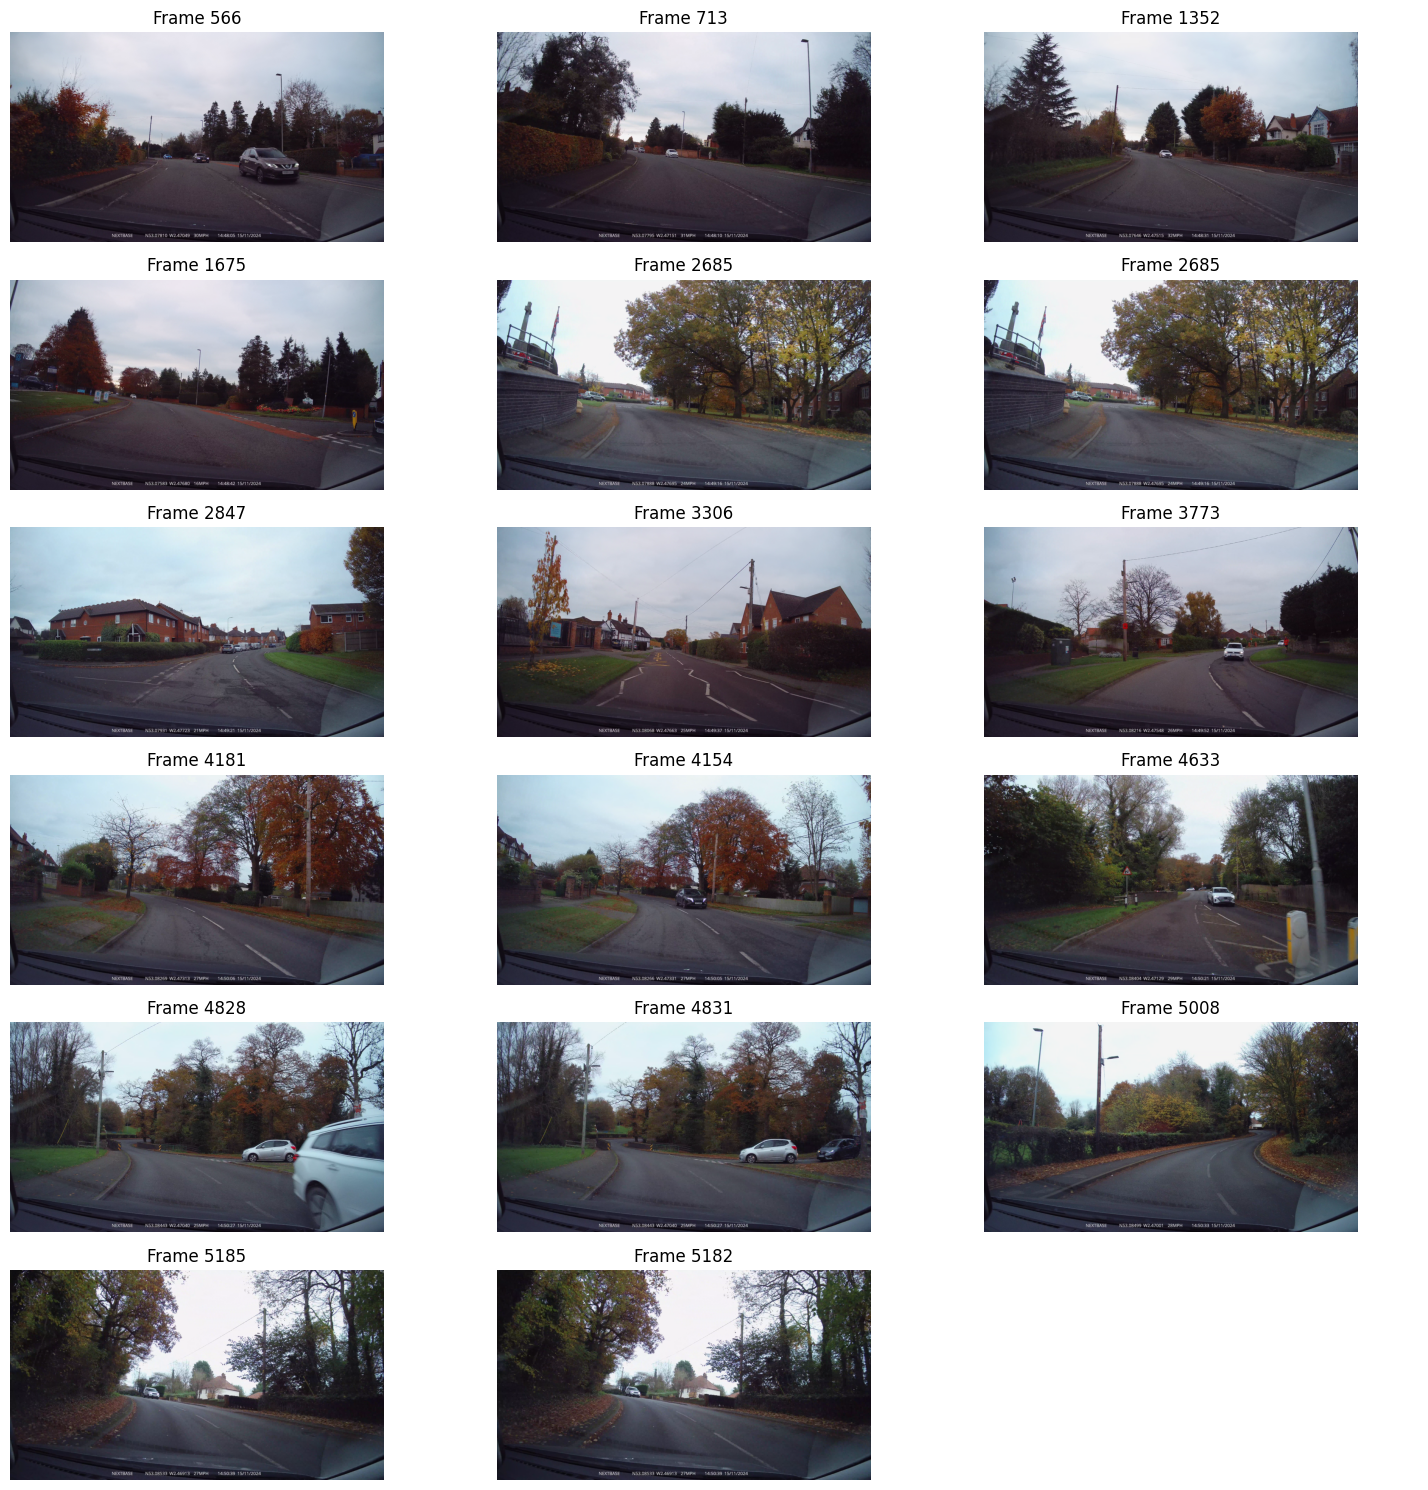

In [323]:
if bends_for_curve_fitting:
	frames = print_frames(df['frame'].tolist())
	for i, frame in enumerate(frames):
		df_row = df.iloc[i]
		output_file = os.path.join(output_folder, f"bend_{i}_frame_{df_row['frame']}_{df_row['bend_direction']}_speed_{int(df_row['avg_speed'])}_angle_{int(df_row['average_bend_angle'])}.jpg")
		cv2.imwrite(output_file, frame)
else:
	print("No bends found for curve fitting.")
	


In [324]:
def find_frame_nearest_point_to_given_accumulated_distance(positions:list[float], distance:float):
    """Find the nearest point to a given accumulated distance

    Args:
        positions (list[float]): The list of positions
        distance (float): target distance
    """

    min_distance = float('inf')
    nearest_point = None

    for pos in positions:
        if abs(pos['distance'] - distance) < min_distance:
            min_distance = abs(pos['distance'] - distance)
            nearest_point = pos

    time = nearest_point['time']
    frame = time_stamp_to_frame_number(time)

    return frame


columns = [
    "frame",
    "bend_direction",
    "avg_speed",
    "average_bend_angle",
    "start_of_focused_points_position_accumulated_distance",
    "frame_20_meters_before",
    "frame_30_meters_before",
    "frame_40_meters_before",
    "frame_50_meters_before",
    "frame_75_meters_before",
    "frame_100_meters_before",
    "frame_150_meters_before"
    ]


data_val = []

for i in range(len(df['frame'].tolist())):
    df_row = df.iloc[i]
    bend_accumulated_distance = df_row['start_of_focused_points_position_accumulated_distance']

    frame_20_meters_before = find_frame_nearest_point_to_given_accumulated_distance(positions, bend_accumulated_distance - 20)
    frame_30_meters_before = find_frame_nearest_point_to_given_accumulated_distance(positions, bend_accumulated_distance - 30)
    frame_40_meters_before = find_frame_nearest_point_to_given_accumulated_distance(positions, bend_accumulated_distance - 40)
    frame_50_meters_before = find_frame_nearest_point_to_given_accumulated_distance(positions, bend_accumulated_distance - 50)
    frame_75_meters_before = find_frame_nearest_point_to_given_accumulated_distance(positions, bend_accumulated_distance - 75)
    frame_100_meters_before = find_frame_nearest_point_to_given_accumulated_distance(positions, bend_accumulated_distance - 100)
    frame_150_meters_before = find_frame_nearest_point_to_given_accumulated_distance(positions, bend_accumulated_distance - 150)

    data_val.append([
        df_row['frame'],
        df_row['bend_direction'],
        df_row['avg_speed'],
        df_row['average_bend_angle'],
        df_row['start_of_focused_points_position_accumulated_distance'],
        frame_20_meters_before,
        frame_30_meters_before,
        frame_40_meters_before,
        frame_50_meters_before,
        frame_75_meters_before,
        frame_100_meters_before,
        frame_150_meters_before
    ])


df_with_accumulated_distance = pd.DataFrame(data_val, columns=columns)
df_with_accumulated_distance

frame bend_direction  avg_speed  average_bend_angle  \
0     566           Left  31.453393           -4.800311   
1     713           Left  31.672427           -4.914410   
2    1352           Left  28.521587           -3.413632   
3    1675          Right  21.143569           39.402110   
4    2685           Left  22.689075          -14.090377   
5    2685           Left  22.312571          -13.640469   
6    2847          Right  22.980357            7.194526   
7    3306           Left  27.079212           -3.487285   
8    3773          Right  27.766434            9.078461   
9    4181           Left  29.069468           -6.189617   
10   4154           Left  28.902740           -6.098564   
11   4633          Right  28.296233            4.043825   
12   4828           Left  27.676789          -11.696337   
13   4831           Left  26.846444          -13.678043   
14   5008          Right  26.536628           11.776686   
15   5185           Left  26.084803          -13.470052   
16   5182           Left  25.890205          -12.925423   

    start_of_focused_points_position_accumulated_distance  \
0                                          267.254144       
1                                          336.857642       
2                                          641.654620       
3                                          767.146943       
4                                         1127.101874       
5                                         1127.101874       
6                                         1183.058346       
7                                         1339.689789       
8                                         1529.622634       
9                                         1702.191020       
10                                        1690.959226       
11                                        1902.020977       
12                                        1980.375335       
13                                        1981.461098       
14                                        2052.910264       
15                                        2125.421438       
16                                        2124.234514       

    frame_20_meters_before  frame_30_meters_before  frame_40_meters_before  \
0                      524                     500                     480   
1                      671                     650                     629   
2                     1310                    1289                    1268   
3                     1600                    1570                    1543   
4                     2628                    2601                    2574   
5                     2628                    2601                    2574   
6                     2787                    2757                    2730   
7                     3255                    3231                    3207   
8                     3725                    3698                    3674   
9                     4133                    4109                    4085   
10                    4106                    4082                    4061   
11                    4588                    4567                    4546   
12                    4774                    4750                    4723   
13                    4777                    4753                    4726   
14                    4963                    4936                    4912   
15                    5137                    5113                    5086   
16                    5134                    5110                    5083   

    frame_50_meters_before  frame_75_meters_before  frame_100_meters_before  \
0                      459                     405                      354   
1                      608                     554                      500   
2                     1247                    1196                     1145   
3                     1519                    1460                     1406   
4                     2547                

In [293]:
csv_save_path = os.path.join(output_folder, "bend_directions.csv")
df_with_accumulated_distance.to_csv(csv_save_path, index=False)
print(f"Saved bend directions to {csv_save_path}")

Saved bend directions to /home/aap9002/Stereo-Road-Curvature-Dashcam/day/012/bends/bend_directions.csv


In [332]:
def resize_frame_to_224(frame):
    """Resize the frame to 224x224

    Args:
        frame (np.ndarray): The frame

    Returns:
        np.ndarray: The resized frame
    """
    # crop 20% off left and right
    frame = frame[:, int(frame.shape[1] * 0.2):int(frame.shape[1] * 0.8)]

    # crop 25% off top and bottom 
    frame = frame[int(frame.shape[0] * 0.25):int(frame.shape[0] * 0.75), :]

    return cv2.resize(frame, (224, 224))

u range: 104 - 151
v range: 97 - 151


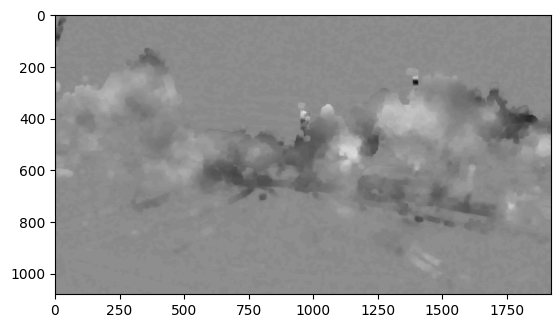

In [335]:
def get_dense_optic_flow_magnitude_and_angle(initial_frame, next_frame):
    """Get the dense optic flow between two frames

    Args:
        initial_frame (np.ndarray): The initial frame
        next_frame (np.ndarray): The next frame

    Returns:
        np.ndarray: The dense optic flow
    """
    
    initial_frame_gray = cv2.cvtColor(initial_frame, cv2.COLOR_BGR2GRAY)
    next_frame_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # reduce image size
    initial_frame_gray = cv2.resize(initial_frame_gray, (int(initial_frame_gray.shape[1] * 0.5), int(initial_frame_gray.shape[0] * 0.5)))
    next_frame_gray = cv2.resize(next_frame_gray, (int(next_frame_gray.shape[1] * 0.5), int(next_frame_gray.shape[0] * 0.5)))

    flow = cv2.calcOpticalFlowFarneback(initial_frame_gray, next_frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    magnitude = magnitude * np.cos(angle)

    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    magnitude = cv2.convertScaleAbs(magnitude)

    angle = np.cos(angle)
    
    angle = cv2.normalize(angle, None, 0, 180, cv2.NORM_MINMAX)
    angle = cv2.convertScaleAbs(angle)


    return magnitude, angle

def get_dense_optic_flow_u_v_flow(initial_frame, next_frame): 
    initial_frame_gray = cv2.cvtColor(initial_frame, cv2.COLOR_BGR2GRAY)
    next_frame_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # reduce image size
    initial_frame_gray = cv2.resize(initial_frame_gray, (int(initial_frame_gray.shape[1] * 0.5), int(initial_frame_gray.shape[0] * 0.5)))
    next_frame_gray = cv2.resize(next_frame_gray, (int(next_frame_gray.shape[1] * 0.5), int(next_frame_gray.shape[0] * 0.5)))

    flow = cv2.calcOpticalFlowFarneback(initial_frame_gray, next_frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    u = flow[..., 0]
    v = flow[..., 1]

    scale = 0.5

    u = u * scale
    v = v * scale

    mid = 255//2

    u = (u + mid).astype(np.uint8)
    v = (v + mid).astype(np.uint8)

    # hard clipping
    u = np.clip(u, 0, 255)
    v = np.clip(v, 0, 255)

    return u, v

    # # normalise with hard clipping to fit 0 - 255 range for storing in AVI file
    # max_val, min_val = 255, -255

    # # cap at min max and divide by 2
    # u = np.clip(u, min_val, max_val) // 2
    # v = np.clip(v, min_val, max_val) // 2

    # # midpoint normalize

    # u = (u + mid).astype(np.uint8)
    # v = (v + mid).astype(np.uint8)

    # # ensure hard clipping to 0 - 255
    # u = np.clip(u, 0, 255)
    # v = np.clip(v, 0, 255)
    
    # # print(f"u range: {np.min(u)} - {np.max(u)}")
    # # print(f"v range: {np.min(v)} - {np.max(v)}")

    # return u, v

dummy_frame = frames[0]
next_frame = frames[3]

# magnitude, angle = get_dense_optic_flow_magnitude_and_angle(dummy_frame, next_frame)
u_change, v_change = get_dense_optic_flow_u_v_flow(dummy_frame, next_frame)

print(f"u range: {np.min(u_change)} - {np.max(u_change)}")
print(f"v range: {np.min(v_change)} - {np.max(v_change)}")

plt.imshow(u_change, cmap='gray')

plt.imshow(v_change, cmap='gray')

# plt.imshow(angle, cmap='gray')

In [296]:
MIN_FRAME = 0
MAX_FRAME = total_frames
video_frame_length = 60

def save_avi_from_to(path, from_frame, to_frame):
    """Save a video from a given frame to another

    Args:
        path (str): The path to the video
        from_frame (int): The starting frame
        to_frame (int): The ending frame
    """

    cap = cv2.VideoCapture(file_path, cv2.CAP_FFMPEG)

    sample_frame = cap.read()[1]

    sample_frame = resize_frame_to_224(sample_frame)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    print(f"image shape: {sample_frame.shape}")

    out = cv2.VideoWriter(path, fourcc, 15.0, (int(sample_frame.shape[1]), int(sample_frame.shape[0])))

    cap.set(cv2.CAP_PROP_POS_FRAMES, from_frame)
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frame = resize_frame_to_224(frame)
            out.write(frame)
        else:
            break

        ret, frame = cap.read() # skip a frame

        if cap.get(cv2.CAP_PROP_POS_FRAMES) >= to_frame:
            break

    cap.release()
    out.release()

In [297]:
def save_optic_flow_avi_from_to(path, from_frame, to_frame):
    """Save a video from a given frame to another

    Args:
        path (str): The path to the video
        from_frame (int): The starting frame
        to_frame (int): The ending frame
    """

    cap = cv2.VideoCapture(file_path, cv2.CAP_FFMPEG)
    cap.set(cv2.CAP_PROP_POS_FRAMES, from_frame)

    # compensate for the skipped frame
    to_frame = min(to_frame+1, MAX_FRAME)

    last_frame = cap.read()[1]

    sample_frame = resize_frame_to_224(last_frame)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    print(f"image shape: {sample_frame.shape}")

    out = cv2.VideoWriter(path, fourcc, 15.0, (int(sample_frame.shape[1]), int(sample_frame.shape[0])))

    
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            next_frame = frame
            # magnitude, angle = get_dense_optic_flow(last_frame, next_frame)

            # new_image = np.zeros((magnitude.shape[0], magnitude.shape[1], 3), dtype=np.uint8)
            # new_image[..., 0] = magnitude
            # new_image[..., 1] = angle    

            # new_image = resize_frame_to_224(new_image)     
            u_change, v_change = get_dense_optic_flow_u_v_flow(last_frame, next_frame)

            new_image = np.ones((u_change.shape[0], u_change.shape[1], 3), dtype=np.uint8)
            new_image[..., 0] = u_change
            new_image[..., 1] = v_change

            new_image = resize_frame_to_224(new_image)

            last_frame = next_frame

            # set last channel to grayscale of original frame
            frame = resize_frame_to_224(frame)
            new_image[..., 2] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


            out.write(new_image)
        else:
            break

        ret, frame = cap.read() # skip a frame

        if cap.get(cv2.CAP_PROP_POS_FRAMES) >= to_frame:
            break

    cap.release()
    out.release()

In [325]:
# create vid_samples folder id not exists
samples_output_folder = os.path.join(output_folder, "vid_samples")
if not os.path.exists(samples_output_folder):
    os.makedirs(samples_output_folder)

samples_output_folder = os.path.join(samples_output_folder, "RGB")
if not os.path.exists(samples_output_folder):
    os.makedirs(samples_output_folder)

samples_OF_output_folder = os.path.join(output_folder, "vid_samples", "OpticFlow")
if not os.path.exists(samples_OF_output_folder):
    os.makedirs(samples_OF_output_folder)

last_bend_frame = None

for i in range(len(df_with_accumulated_distance['frame'].tolist())):
    df_row = df_with_accumulated_distance.iloc[i]

    bend_frame = df_row['frame']

    distance_columns = [col for col in df_with_accumulated_distance.columns if '_meters_before' in col]

    direction = df_row['bend_direction']
    speed = int(df_row['avg_speed'])
    accumulated_distance = df_row['start_of_focused_points_position_accumulated_distance']
    avg_angle = int(df_row['average_bend_angle'])

    for distance_column in distance_columns:
        distance = int(distance_column.split('_')[1].split('_')[0])        

        start_frame = df_row[distance_column]
        if start_frame < MIN_FRAME:
            start_frame = MIN_FRAME

        if last_bend_frame is not None and start_frame < last_bend_frame:
            print(f"Skipping bend {i} {distance} meters - infringes on previous bend")
            continue

        end_frame = start_frame + video_frame_length
        if end_frame > bend_frame:
            print(f"run up too short for bend {i} - {direction} - {speed} MPH - {distance} meters - {end_frame - start_frame} frames")
            continue

        temp_file_path = os.path.join(samples_output_folder, f"bend_{i}_{start_frame}_{end_frame}_{direction}_{speed}_{avg_angle}_{distance}_meters_before.avi")
        save_avi_from_to(temp_file_path, start_frame, end_frame)
        print(f"Saved videos for bend {i} - {direction} - {speed} MPH - {distance} meters - from {start_frame} to {end_frame} {temp_file_path}")
        save_optic_flow_avi_from_to(temp_file_path.replace("RGB", "OpticFlow"), start_frame, end_frame)
        print(f"Saved optic flow videos for bend {i} - {direction} - {speed} MPH - {distance} meters - from {start_frame} to {end_frame}")

    last_bend_frame = bend_frame

run up too short for bend 0 - Left - 31 MPH - 20 meters - 60 frames
image shape: (224, 224, 3)
Saved videos for bend 0 - Left - 31 MPH - 30 meters - from 500 to 560 /home/aap9002/Stereo-Road-Curvature-Dashcam/day/012/bends/vid_samples/RGB/bend_0_500_560_Left_31_-4_30_meters_before.avi
image shape: (224, 224, 3)


KeyboardInterrupt: 